In [5]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import calculate_IV, plot_by_woe

In [2]:
warnings.filterwarnings('ignore') # to supress warnings

In [3]:
sns.set()

In [4]:
# loading training data.
data_in_use = pd.read_csv('dataset/train_input1.csv') # Loading updated data.
output_data = pd.read_csv('dataset/train_output.csv') # Loading updated data.

In [5]:
### Convert the cell above into markdown, before running this cell.

### loading testing data.
# data_in_use = pd.read_csv('dataset/test_input1.csv') # Loading updated data.
# output_data = pd.read_csv('dataset/test_output.csv') # Loading updated data.

# Classing of Continuous Variables

We will now perform **classing (or binning)** on the continuous variables. This process involves dividing the variable ranges into meaningful intervals to better capture patterns in default behavior.

Once the binning is complete, we will create **dummy variables** (one-hot encoding) for each bin to prepare the data for modeling.

### Binning Strategy: `pd.cut()` + WOE-Based Filtering

In this project, a **two-step approach** for binning the continuous variable (like `int_rate`) is used.

#### Step 1: Initial Fine Binning using `pd.cut()`

- Starting with `pd.cut()` to create **initial fine bins** of the continous variable.
- This helped segment the variable into **interpretable ranges** and laid the foundation for WOE analysis.
- While `pd.cut()` does not account for the distribution of the target variable, it provides a quick and controlled way to define custom bins.

#### Step 2: Filtering & Refinement using WOE and IV

- After the initial binning, **WOE (Weight of Evidence)** and **IV (Information Value)** for each bin is calculated.
- Then similar to the discrete variables coarse classing, we analyse **WOE** and **IV** to **merge** or **adjusted bins** that had:
  - Similar WOE values,
  - Non-monotonic trends,
  - Or low predictive power.

#### Variables in focus are:
> **a) months_since_issue_date**
> 
> **b) int_rate (Interest rate)**
> 
> **c) funded_amnt (loan amount)**
>
> **d) installment**
>
> **e) delinq_2yrs**
>
> **f) inq_last_6mths**
>
> **g) open_acc**
> 
> **h) pub_rec**
>
> **i) total_acc**
>
> **j) acc_now_delinq**
>
> **k) months_since_earliest_cr_line**


### 📌 Note:

#### The variables **`annual_inc`**, **`dti (debt to income ratio)`**, **`mths_since_last_record`**, and **`mths_since_last_delinq`** also require preprocessing. However, since they involve additional handling steps, their treatment will be discussed **separately at the end** of the preprocessing section.

In [6]:
# months_since_issue_date:- Total of 139 distinct categories.

variable_list = ['months_since_issue_date', 'int_rate', 'funded_amnt', 'installment', 'total_acc',
                'months_since_earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs', 'open_acc',
                'pub_rec', 'inq_last_6mths']

for i in variable_list:
    print(f"{i}: Total of {len(data_in_use[i].unique())} distinct categories.", "\n")

months_since_issue_date: Total of 139 distinct categories. 

int_rate: Total of 669 distinct categories. 

funded_amnt: Total of 1570 distinct categories. 

installment: Total of 89055 distinct categories. 

total_acc: Total of 153 distinct categories. 

months_since_earliest_cr_line: Total of 742 distinct categories. 

acc_now_delinq: Total of 9 distinct categories. 

delinq_2yrs: Total of 34 distinct categories. 

open_acc: Total of 87 distinct categories. 

pub_rec: Total of 40 distinct categories. 

inq_last_6mths: Total of 26 distinct categories. 



> **Note:** Although variables like `months_since_issue_date`, `int_rate`, `funded_amnt`, and others are categorical variable with discrete values, but they have too many categories for practical use in a model as dummy variables. Therefore, we will treat them as **continuous variables** and perform **binning** into groups of similar values, before using them in the model.
>
> **Strategy:** we will perform **binning** of a variable if it has more than 100 categories.
>
## First, we will work with the variables that had more than 100 categories.
>
> > **Variables with more than 100 categories are:**
>
> > > months_since_issue_date
> > > 
> > > int_rate
> > > 
> > > funded_amnt
> > >
> > > months_since_earliest_cr_line
> > >
> > > total_acc
> > >
> > > installment
> > >
---



In [7]:
# Creating 50 categories for WOE analyse using pd.cut() for each variable.
data_in_use["months_since_issue_date_factor"] = pd.cut(data_in_use["months_since_issue_date"], 50)
data_in_use["int_rate_factor"] = pd.cut(data_in_use["int_rate"], 50)
data_in_use["funded_amnt_factor"] = pd.cut(data_in_use["funded_amnt"], 50)
data_in_use["installment_factor"] = pd.cut(data_in_use["installment"], 50)
data_in_use["total_acc_factor"] = pd.cut(data_in_use["total_acc"], 50)
data_in_use["months_since_earliest_cr_line_factor"] = pd.cut(data_in_use["months_since_earliest_cr_line"], 50)

In [8]:
iv_per_var_con = {}
list_of_variables = ["months_since_issue_date_factor","int_rate_factor", "funded_amnt_factor",
                    "installment_factor", "total_acc_factor", "months_since_earliest_cr_line_factor"] 

# loan_status is not inlcuded as it was used to derive our dependent variable (or True values.)

for var in list_of_variables:
    df_woe, iv_grade = calculate_IV(data_in_use, output_data, var, dtype = "continous")
    iv_per_var_con[var] = [iv_grade, df_woe]

Information Value (IV) for variable months_since_issue_date_factor: 0.5422
Information Value (IV) for variable int_rate_factor: 0.4733
Information Value (IV) for variable funded_amnt_factor: 0.0423
Information Value (IV) for variable installment_factor: 0.0255
Information Value (IV) for variable total_acc_factor: 0.0026
Information Value (IV) for variable months_since_earliest_cr_line_factor: 0.0131


---
### **Analysing WOE of months_since_issue_date**

In [9]:
iv_per_var_con["months_since_issue_date_factor"][1]

,months_since_issue_date_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(79.862, 82.76]",102506,0.056679,102072.0,434.0,0.064559,0.001908,0.995766,3.521579,2.206317e-01
1,"(82.76, 85.52]",102745,0.056811,101048.0,1697.0,0.063912,0.007460,0.983483,2.147924,1.212534e-01
2,"(85.52, 88.28]",104704,0.057894,100762.0,3942.0,0.063731,0.017329,0.962351,1.302263,6.042674e-02
3,"(88.28, 91.04]",86289,0.047712,81659.0,4630.0,0.051648,0.020354,0.946343,0.931185,2.914090e-02
4,"(91.04, 93.8]",64455,0.035639,59804.0,4651.0,0.037825,0.020446,0.927841,0.615180,1.069127e-02
5,"(93.8, 96.56]",97052,0.053663,88084.0,8968.0,0.055712,0.039424,0.907596,0.345818,5.632660e-03
6,"(96.56, 99.32]",92397,0.051089,82341.0,10056.0,0.052080,0.044207,0.891165,0.163890,1.290239e-03
7,"(99.32, 102.08]",75711,0.041863,66705.0,9006.0,0.042190,0.039591,0.881048,0.063579,1.652365e-04
8,"(102.08, 104.84]",54628,0.030206,47096.0,7532.0,0.029788,0.033111,0.862122,-0.105782,3.515889e-04
9,"(104.84, 107.6]",76322,0.042201,65262.0,11060.0,0.041277,0.048621,0.855088,-0.163735,1.202359e-03


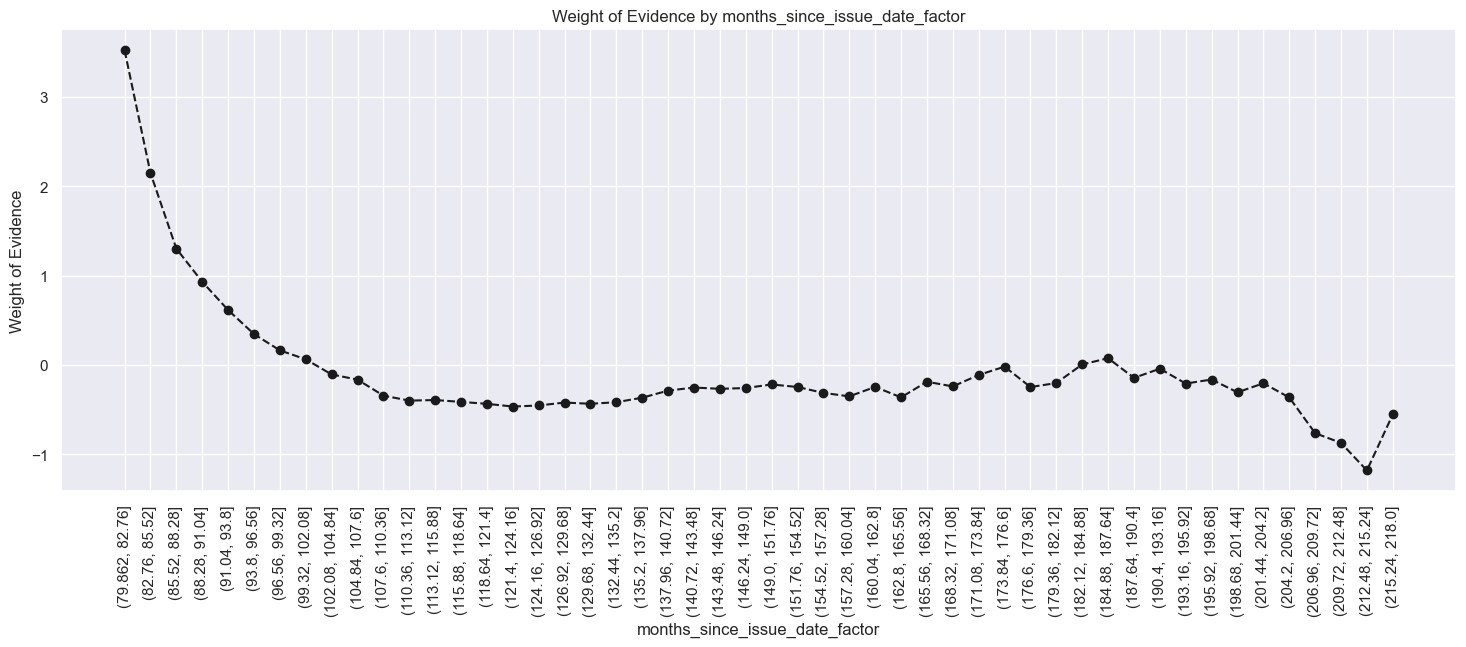

In [10]:
plot_by_woe(iv_per_var_con["months_since_issue_date_factor"][1], rotation_of_x_axis_labels = 90) 

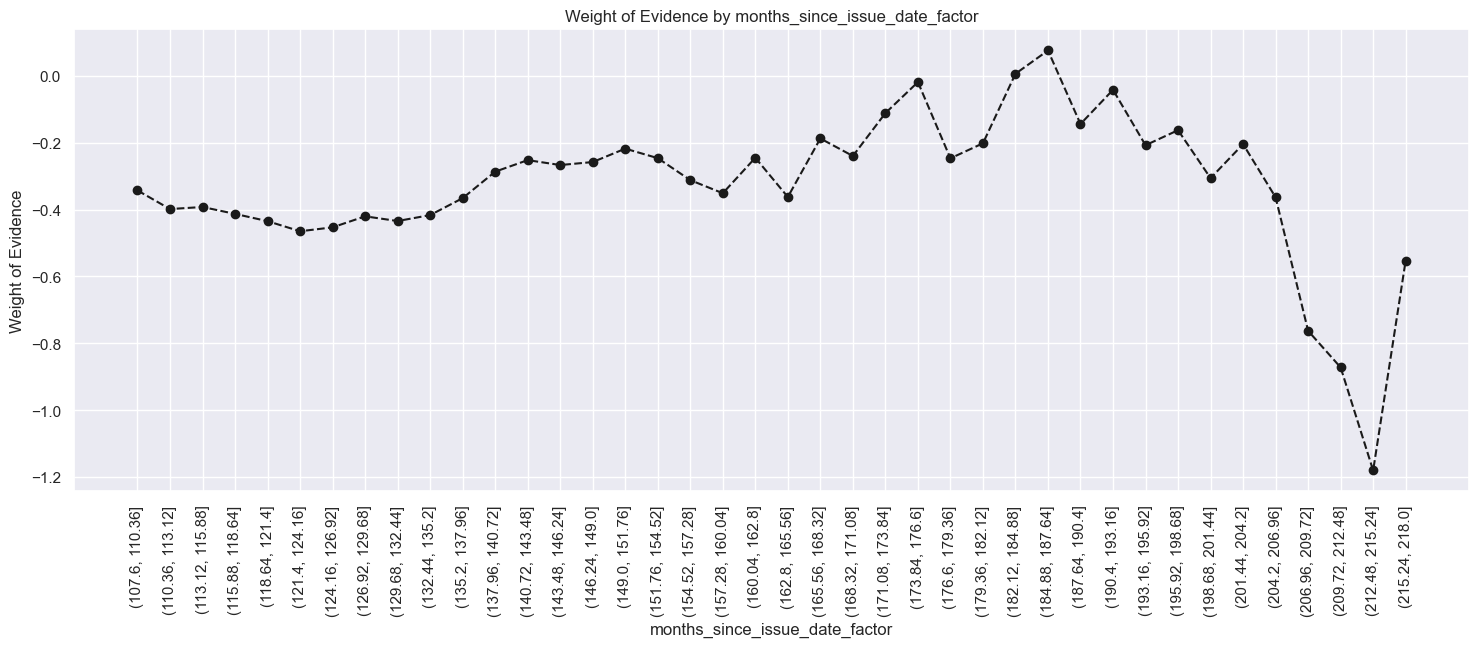

In [11]:
plot_by_woe(iv_per_var_con["months_since_issue_date_factor"][1][10:], rotation_of_x_axis_labels = 90) 

In [12]:
data_in_use['months_since_issue_date:<83'] = np.where(data_in_use["months_since_issue_date"].isin(range(83)), 1, 0)
data_in_use['months_since_issue_date:83-86'] = np.where(data_in_use["months_since_issue_date"].isin(range(83, 86)), 1, 0)
data_in_use['months_since_issue_date:86-89'] = np.where(data_in_use["months_since_issue_date"].isin(range(86, 89)), 1, 0)
data_in_use['months_since_issue_date:89-91'] = np.where(data_in_use["months_since_issue_date"].isin(range(89, 91)), 1, 0)
data_in_use['months_since_issue_date:91-94'] = np.where(data_in_use["months_since_issue_date"].isin(range(91, 94)), 1, 0)
data_in_use['months_since_issue_date:94-97'] = np.where(data_in_use["months_since_issue_date"].isin(range(94, 97)), 1, 0)
data_in_use['months_since_issue_date:97-99'] = np.where(data_in_use["months_since_issue_date"].isin(range(97, 99)), 1, 0)
data_in_use['months_since_issue_date:99-102'] = np.where(data_in_use["months_since_issue_date"].isin(range(99, 102)), 1, 0)
data_in_use['months_since_issue_date:102-105'] = np.where(data_in_use["months_since_issue_date"].isin(range(102, 105)), 1, 0)
data_in_use['months_since_issue_date:105-108'] = np.where(data_in_use["months_since_issue_date"].isin(range(105, 108)), 1, 0)
data_in_use['months_since_issue_date:108-138'] = np.where(data_in_use["months_since_issue_date"].isin(range(108, 138)), 1, 0)
data_in_use['months_since_issue_date:138-160'] = np.where(data_in_use["months_since_issue_date"].isin(range(138, 160)), 1, 0)
data_in_use['months_since_issue_date:>160'] = np.where(data_in_use["months_since_issue_date"].isin(range(160,
                                                                    int(data_in_use["months_since_issue_date"].max()))), 1, 0)

### Binning `months_since_issue_date`

To prepare the `months_since_issue_date` variable for modeling, we performed **fine classing** by grouping it into **custom bins** based on:

1. **Similarity in WoE (Weight of Evidence)** values, to ensure each bin reflects similar risk behavior.
2. **Low frequency in higher months** (i.e., very few observations with high values), which are grouped into broader bins to avoid noise.

Each bin is then converted into a **dummy variable** using the `np.where()` function.

#### Binning Logic:

- `<83` : Captures observations with fewer than 83 months since issue.
- `83–86`, `86–89`, `89–91`, `91–94`, `94–97`, `97–99`, `99–102`, `102–105`, `105–108`: These are narrow bins, created due to small yet meaningful shifts in WoE.
- `108–138`: A wider range, capturing stable WoE behavior over many months.
- `138–160`: Transitional period before the very sparse data.
- `>160`: Contains few observations and is grouped together to avoid instability in modeling.

---

## **Analysing WOE of int_rate (Interest rate)** 

In [13]:
iv_per_var_con["int_rate_factor"][1]

,int_rate_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(5.284, 5.824]",45558,0.025191,44635.0,923.0,0.028231,0.004058,0.979740,1.939835,4.689257e-02
1,"(5.824, 6.337]",39238,0.021696,38574.0,664.0,0.024398,0.002919,0.983078,2.123242,4.560420e-02
2,"(6.337, 6.851]",41433,0.022910,40436.0,997.0,0.025575,0.004383,0.975937,1.763915,3.738153e-02
3,"(6.851, 7.364]",76059,0.042056,73430.0,2629.0,0.046444,0.011557,0.965435,1.390919,4.852394e-02
4,"(7.364, 7.878]",43658,0.024140,41988.0,1670.0,0.026557,0.007341,0.961748,1.285750,2.470623e-02
5,"(7.878, 8.392]",110688,0.061203,103672.0,7016.0,0.065571,0.030843,0.936615,0.754229,2.619308e-02
6,"(8.392, 8.905]",29816,0.016486,28333.0,1483.0,0.017920,0.006519,0.950262,1.011150,1.152799e-02
7,"(8.905, 9.419]",37196,0.020567,33539.0,3657.0,0.021213,0.016076,0.901683,0.277256,1.424127e-03
8,"(9.419, 9.932]",79981,0.044224,75079.0,4902.0,0.047487,0.021550,0.938710,0.790088,2.049243e-02
9,"(9.932, 10.446]",63277,0.034988,59045.0,4232.0,0.037345,0.018604,0.933119,0.696815,1.305900e-02


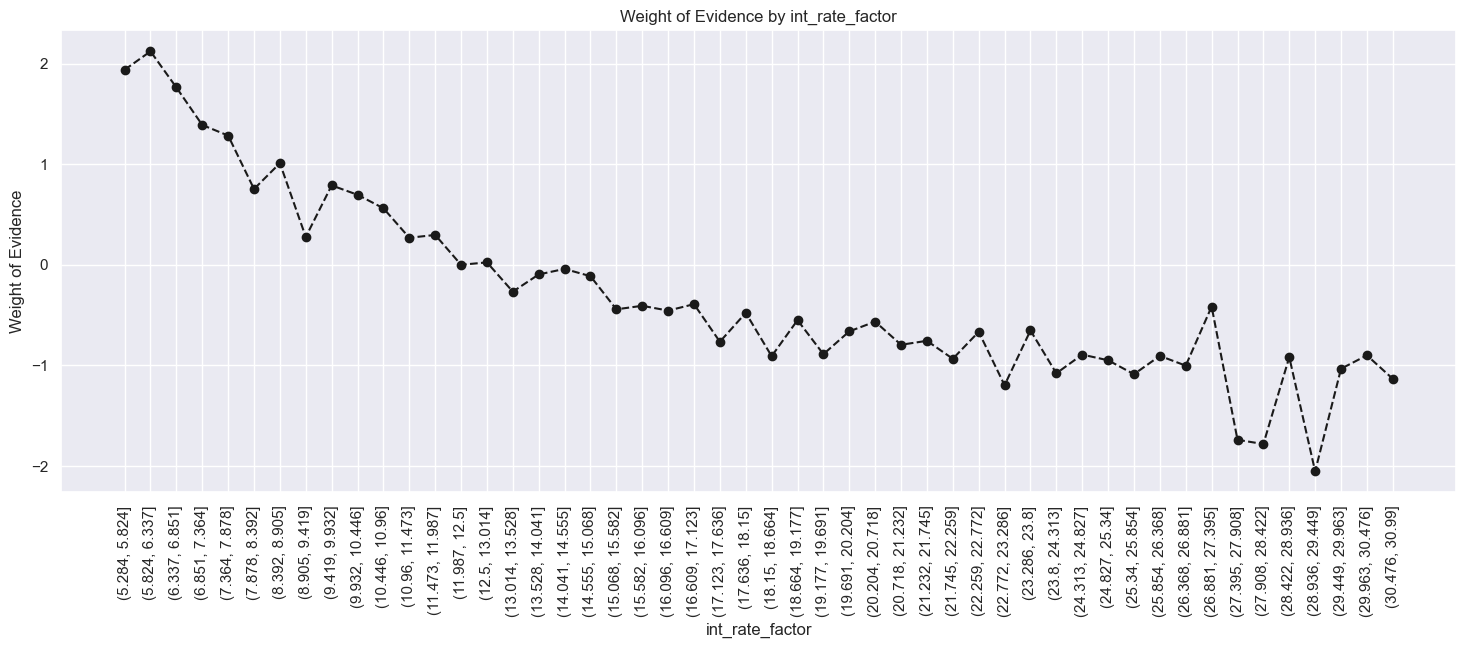

In [14]:
plot_by_woe(iv_per_var_con["int_rate_factor"][1], rotation_of_x_axis_labels = 90) 

### Plot interpretation:- Greater the interest rate, lower the weight of evidence and higher the Probability of Default (PD).

In [15]:
data_in_use['int_rate:<7.878'] = np.where((data_in_use['int_rate'] <= 7.878), 1, 0)

data_in_use['int_rate:7.878-8.392'] = np.where((data_in_use['int_rate'] > 7.878) & 
                                                            (data_in_use['int_rate'] <= 8.392), 1, 0)

data_in_use['int_rate:8.392-10.96'] = np.where((data_in_use['int_rate'] > 8.392) & 
                                                            (data_in_use['int_rate'] <= 10.96), 1, 0)

data_in_use['int_rate:10.96-11.987'] = np.where((data_in_use['int_rate'] > 10.96) & 
                                                            (data_in_use['int_rate'] <= 11.987), 1, 0)

data_in_use['int_rate:11.987-13.014'] = np.where((data_in_use['int_rate'] > 11.987) & 
                                                            (data_in_use['int_rate'] <= 13.014), 1, 0)

data_in_use['int_rate:13.014-15.068'] = np.where((data_in_use['int_rate'] > 13.014) & 
                                                            (data_in_use['int_rate'] <= 15.068), 1, 0)

data_in_use['int_rate:15.068-17.123'] = np.where((data_in_use['int_rate'] > 15.068) & 
                                                            (data_in_use['int_rate'] <= 17.123), 1, 0)

data_in_use['int_rate:17.123-22.772'] = np.where((data_in_use['int_rate'] > 17.123) & 
                                                            (data_in_use['int_rate'] <= 22.772), 1, 0)

data_in_use['int_rate:22.772-26.368'] = np.where((data_in_use['int_rate'] > 22.772) & 
                                                            (data_in_use['int_rate'] <= 26.368), 1, 0)


data_in_use['int_rate:>26.368'] = np.where((data_in_use["int_rate"] > 26.368), 1, 0)
                                                   

### Binning `int_rate` Based on WOE Table

#### 🧪 Binning Strategy

- The **lowest interest rates** (WOE values were high and IV contributions strong), so these bins are kept narrower.
- Then I grouped together ranges where WOE was fairly **stable or showed gradual changes**, indicating similar risk patterns.
- Finally, I combined **sparse or noisy bins** (especially at the higher `int_rate` levels) into a broader range to avoid overfitting.
---

#### 📦 Final Bins

Here are the bins I created:

| Bin Label | Interest Rate Range |
|-----------|---------------------|
| `int_rate:<7.878` | ≤ 7.878 |
| `int_rate:7.878–8.392` | > 7.878 and ≤ 8.392 |
| `int_rate:8.392–10.96` | > 8.392 and ≤ 10.96 |
| `int_rate:10.96–11.987` | > 10.96 and ≤ 11.987 |
| `int_rate:11.987–13.014` | > 11.987 and ≤ 13.014 |
| `int_rate:13.014–15.068` | > 13.014 and ≤ 15.068 |
| `int_rate:15.068–17.123` | > 15.068 and ≤ 17.123 |
| `int_rate:17.123–22.772` | > 17.123 and ≤ 22.772 |
| `int_rate:22.772–26.368` | > 22.772 and ≤ 26.368 |
| `int_rate:>26.368` | > 26.368 |

Each bin was implemented as a binary (0/1) feature for logistic regression, using `np.where`.

---

## **Analysing WOE of funded_amnt** 

In [16]:
iv_per_var_con["funded_amnt_factor"][1]

,funded_amnt_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(460.5, 1290.0]",11342,0.006271,10448.0,894.0,0.006608,0.003930,0.921178,0.519650,1.391689e-03
1,"(1290.0, 2080.0]",25594,0.014152,23254.0,2340.0,0.014708,0.010287,0.908572,0.357516,1.580587e-03
2,"(2080.0, 2870.0]",22296,0.012328,20007.0,2289.0,0.012654,0.010063,0.897336,0.229157,5.938687e-04
3,"(2870.0, 3660.0]",50541,0.027946,45412.0,5129.0,0.028723,0.022548,0.898518,0.242056,1.494692e-03
4,"(3660.0, 4450.0]",39762,0.021986,35558.0,4204.0,0.022490,0.018481,0.894271,0.196319,7.870106e-04
5,"(4450.0, 5240.0]",93823,0.051878,83844.0,9979.0,0.053030,0.043869,0.893640,0.189665,1.737660e-03
6,"(5240.0, 6030.0]",84454,0.046697,75594.0,8860.0,0.047812,0.038949,0.895091,0.205020,1.817079e-03
7,"(6030.0, 6820.0]",27373,0.015135,24006.0,3367.0,0.015183,0.014802,0.876996,0.025472,9.726872e-06
8,"(6820.0, 7610.0]",63240,0.034968,56040.0,7200.0,0.035445,0.031652,0.886148,0.113175,4.292460e-04
9,"(7610.0, 8400.0]",81099,0.044842,71428.0,9671.0,0.045177,0.042515,0.880751,0.060748,1.617580e-04


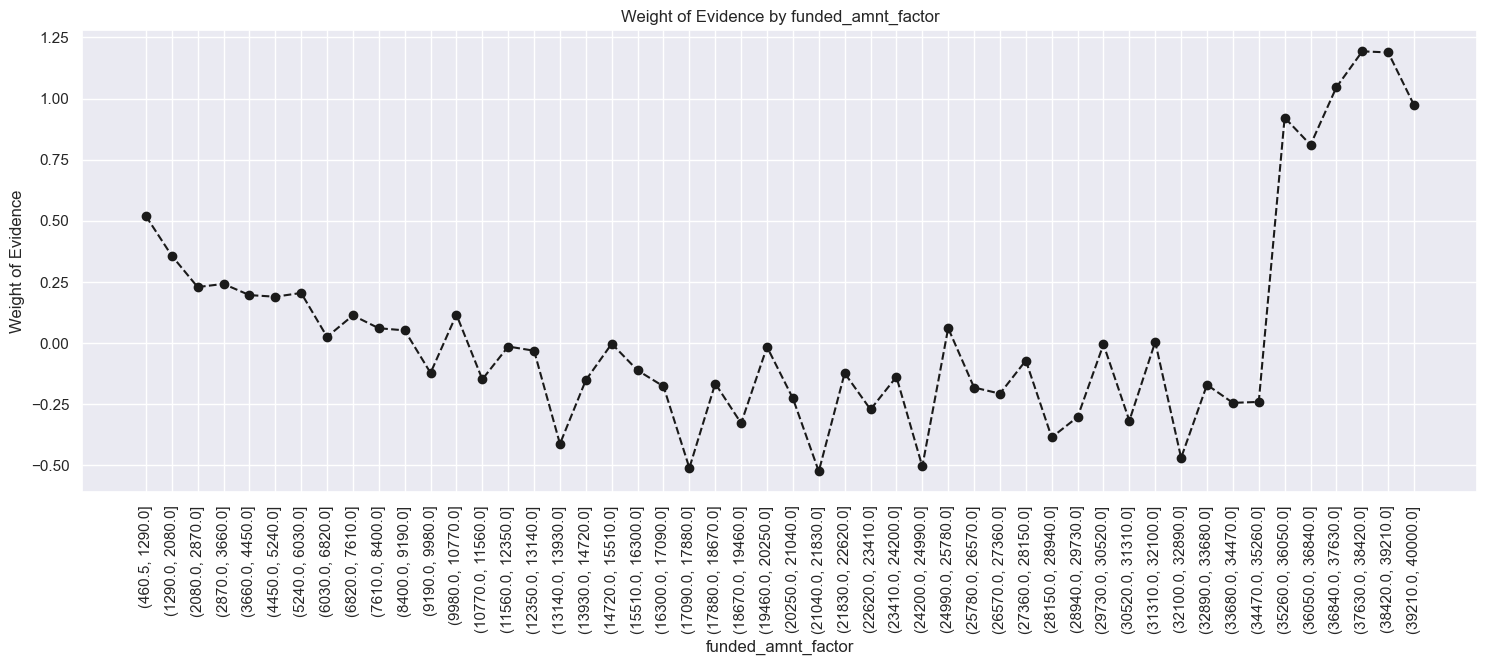

In [17]:
plot_by_woe(iv_per_var_con["funded_amnt_factor"][1], rotation_of_x_axis_labels = 90) 

> ### Note:
> The variable `funded_amnt_factor` has an Information Value (IV) of **0.0423**, which indicates **weak predictive power**, but it is **not useless**. Therefore, we will retain the variable and perform **classing using Weight of Evidence (WOE)**.
>
> From the WOE plot, it is evident that the categories in the range **35,260.0 to 40,000.0** exhibit the **highest WOE values**, indicating a **lower probability of default**. Hence, these categories can be **binned together** to improve model performance and stability.


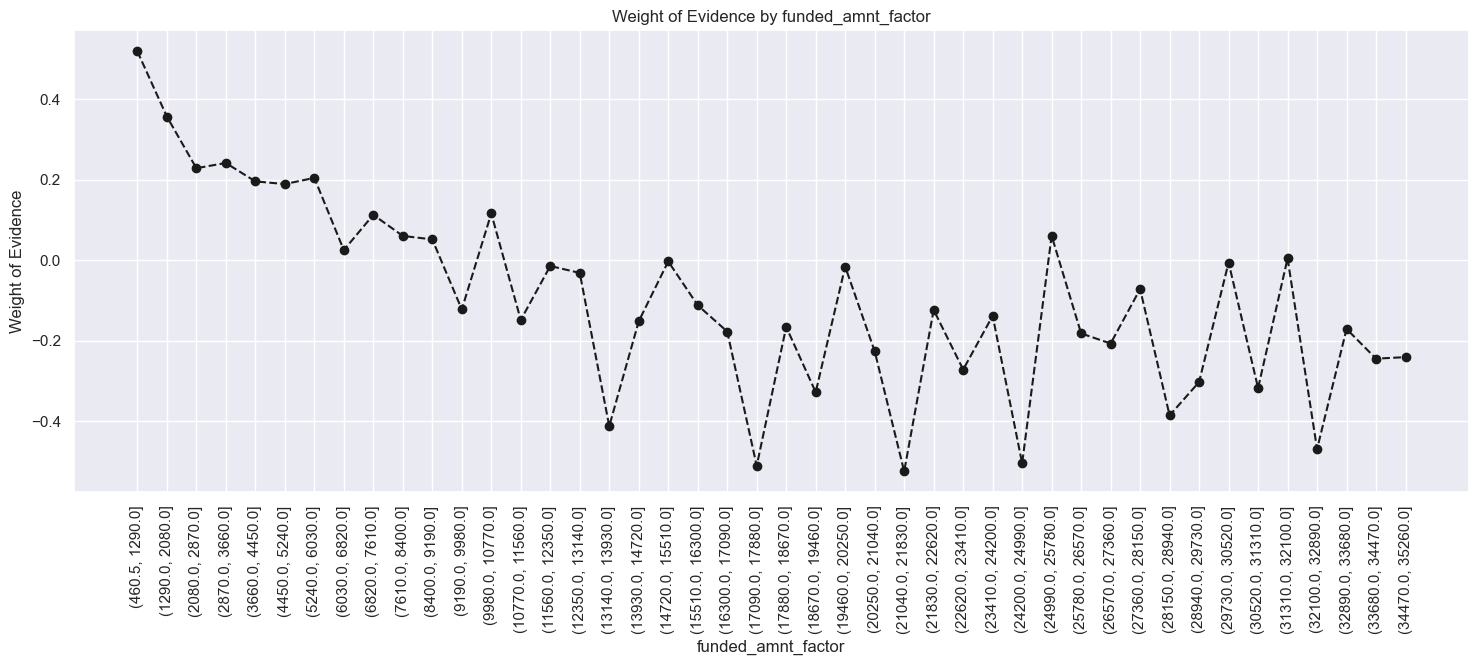

In [18]:
plot_by_woe(iv_per_var_con["funded_amnt_factor"][1][:-6], rotation_of_x_axis_labels = 90) 

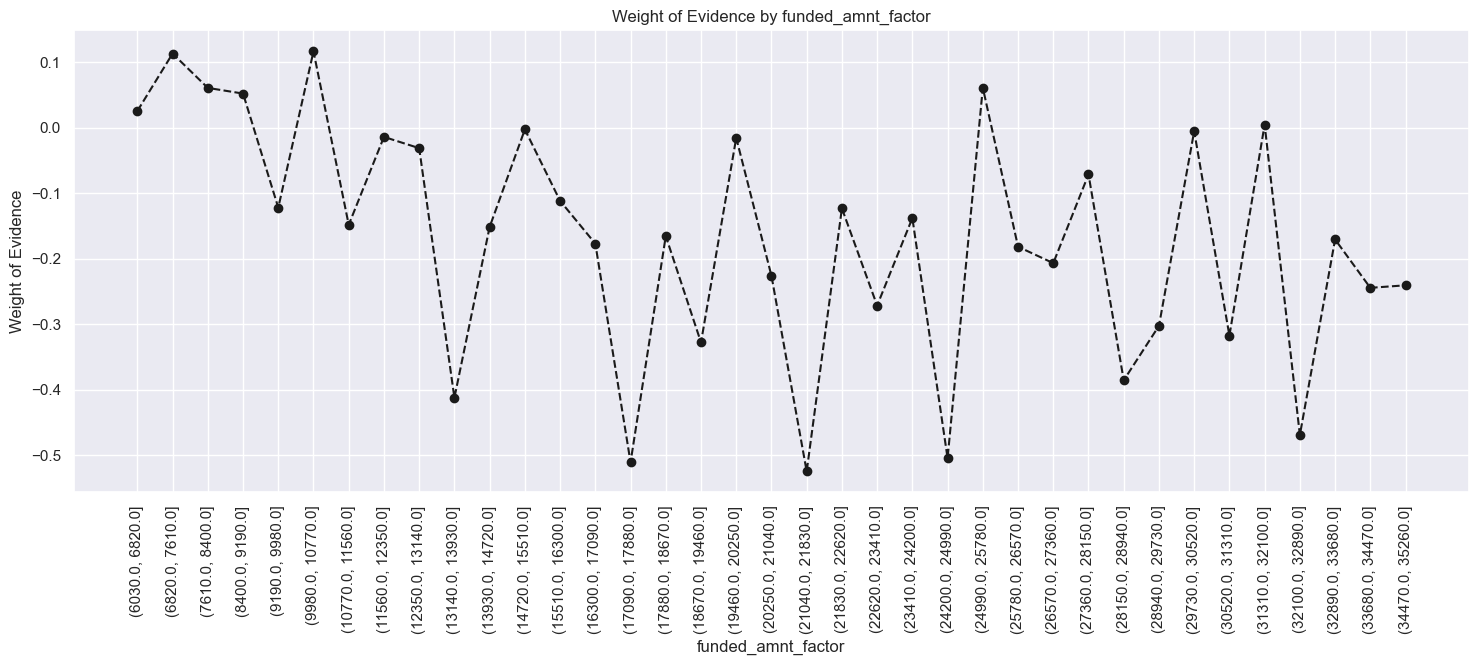

In [19]:
plot_by_woe(iv_per_var_con["funded_amnt_factor"][1][7:-6], rotation_of_x_axis_labels = 90) 

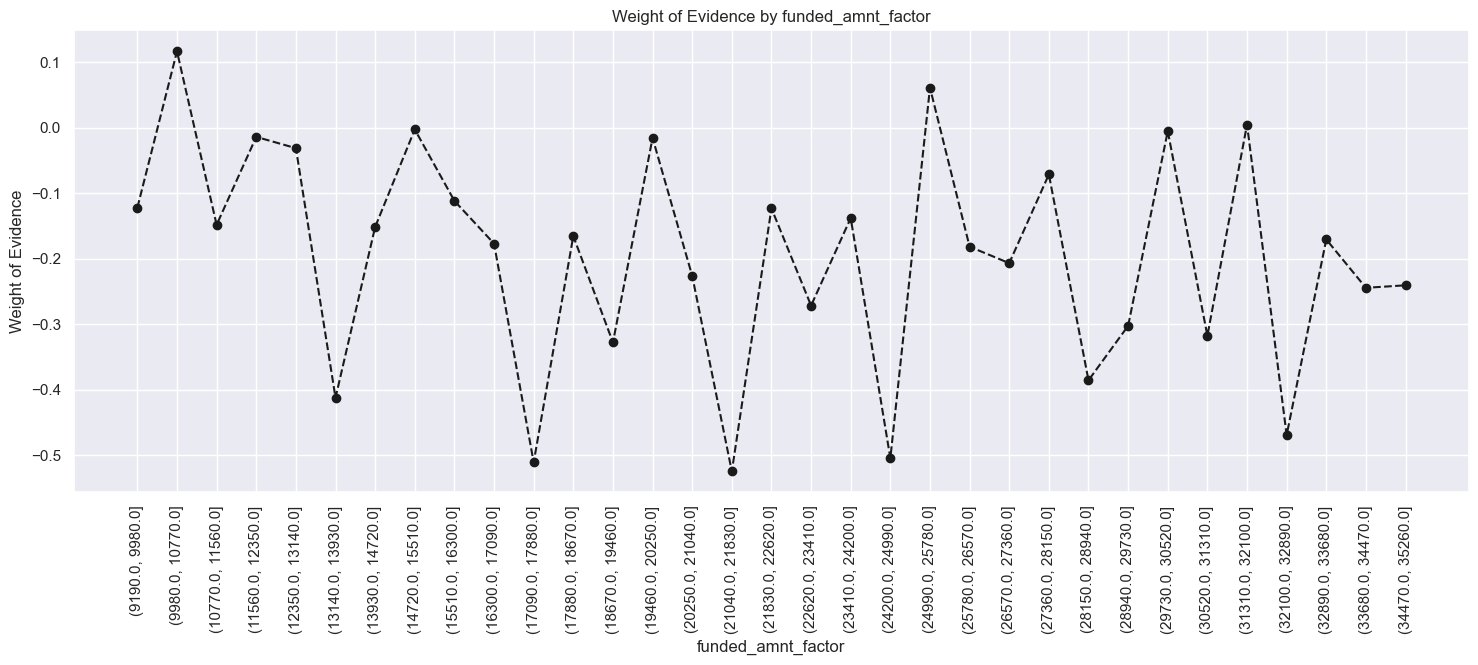

In [20]:
plot_by_woe(iv_per_var_con["funded_amnt_factor"][1][11:-6], rotation_of_x_axis_labels = 90) 

In [21]:
data_in_use['funded_amnt:<1290'] = np.where(data_in_use["funded_amnt"] < 1290, 1, 0)

data_in_use['funded_amnt:1290-2080'] = np.where((data_in_use["funded_amnt"] >= 1290) & 
                                                            (data_in_use["funded_amnt"] < 2080), 1, 0)

data_in_use['funded_amnt:2080-2870'] = np.where((data_in_use["funded_amnt"] >= 2080) & 
                                                            (data_in_use["funded_amnt"] < 2870), 1, 0)

data_in_use['funded_amnt:2870-6030'] = np.where((data_in_use["funded_amnt"] >= 2870) & 
                                                            (data_in_use["funded_amnt"] < 6030), 1, 0)

data_in_use['funded_amnt:6030-9190'] = np.where((data_in_use["funded_amnt"] >= 6030) & 
                                                            (data_in_use["funded_amnt"] < 9190), 1, 0)

data_in_use['funded_amnt:9190-35260'] = np.where((data_in_use["funded_amnt"] >= 9190) & 
                                                             (data_in_use["funded_amnt"] < 35260), 1, 0)

data_in_use['funded_amnt:>35260'] = np.where(data_in_use["funded_amnt"] >= 35260, 1, 0)


## **Analysing WOE of installment** 

- The Information Value (IV) is **0.026**, which is slightly above the 0.02 threshold, it still falls into the category of **"weak predictive power"**.

In [22]:
iv_per_var_con["installment_factor"][1]

,installment_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(3.215, 39.228]",8487,4.692751e-03,7819.0,668.0,4.945419e-03,0.002937,0.921291,0.521214,1.047032e-03
1,"(39.228, 73.526]",29348,1.622751e-02,26757.0,2591.0,1.692347e-02,0.011390,0.911715,0.395942,2.190830e-03
2,"(73.526, 107.824]",48365,2.674265e-02,43726.0,4639.0,2.765615e-02,0.020393,0.904084,0.304634,2.212466e-03
3,"(107.824, 142.122]",55928,3.092449e-02,50350.0,5578.0,3.184574e-02,0.024521,0.900265,0.261359,1.914286e-03
4,"(142.122, 176.42]",95832,5.298877e-02,86006.0,9826.0,5.439772e-02,0.043196,0.897466,0.230575,2.582850e-03
5,"(176.42, 210.718]",94578,5.229540e-02,84711.0,9867.0,5.357865e-02,0.043376,0.895673,0.211240,2.155164e-03
6,"(210.718, 245.016]",95306,5.269793e-02,84941.0,10365.0,5.372412e-02,0.045565,0.891245,0.164712,1.343834e-03
7,"(245.016, 279.314]",122708,6.784943e-02,107457.0,15251.0,6.796521e-02,0.067045,0.875713,0.013636,1.255149e-05
8,"(279.314, 313.612]",116732,6.454510e-02,102595.0,14137.0,6.489005e-02,0.062147,0.878894,0.043184,1.184346e-04
9,"(313.612, 347.91]",142356,7.871348e-02,124397.0,17959.0,7.867954e-02,0.078949,0.873844,-0.003423,9.235325e-07


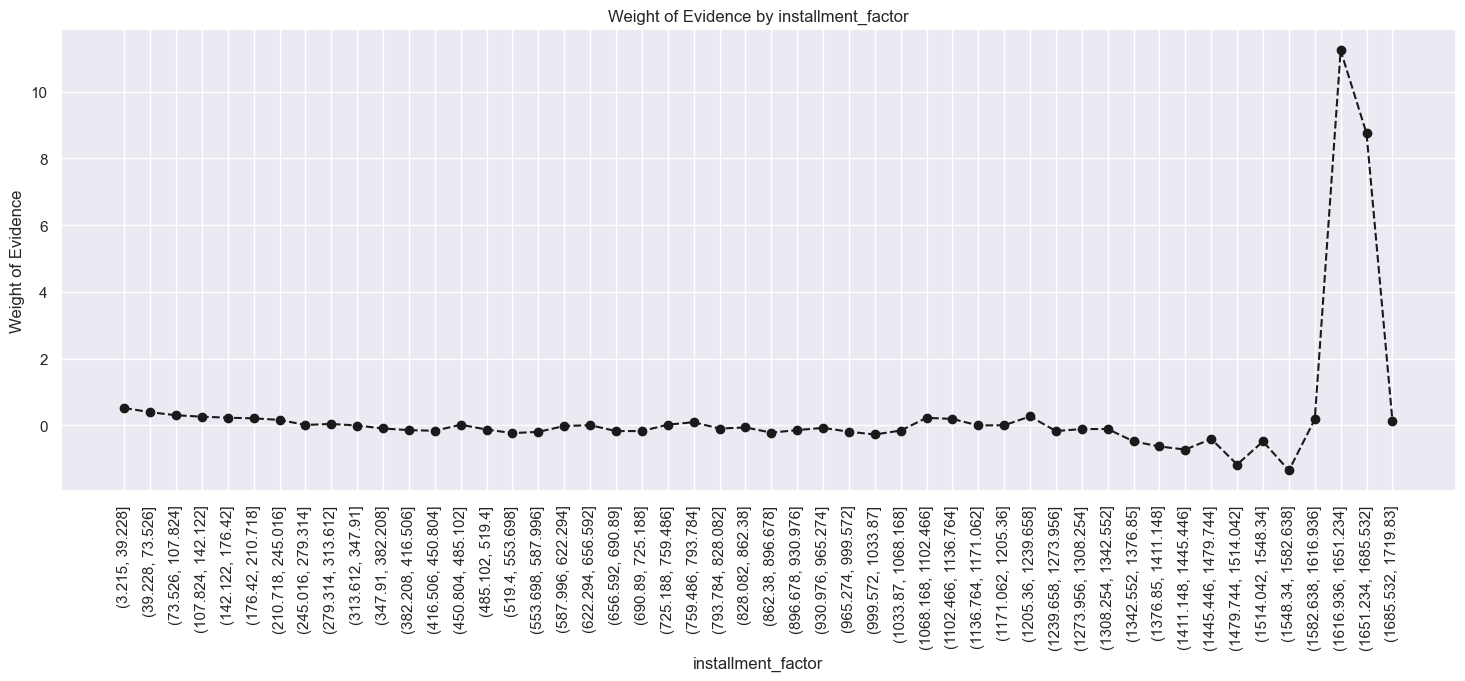

In [23]:
plot_by_woe(iv_per_var_con["installment_factor"][1], rotation_of_x_axis_labels = 90)

### The above plot is not highlighting the tru relationship between installment and WOE. This is because after index 28 the number of observations in each bin are very less as compared to the other bins. So, if we exclude those categories and visualise installment variaction with WOE, we get

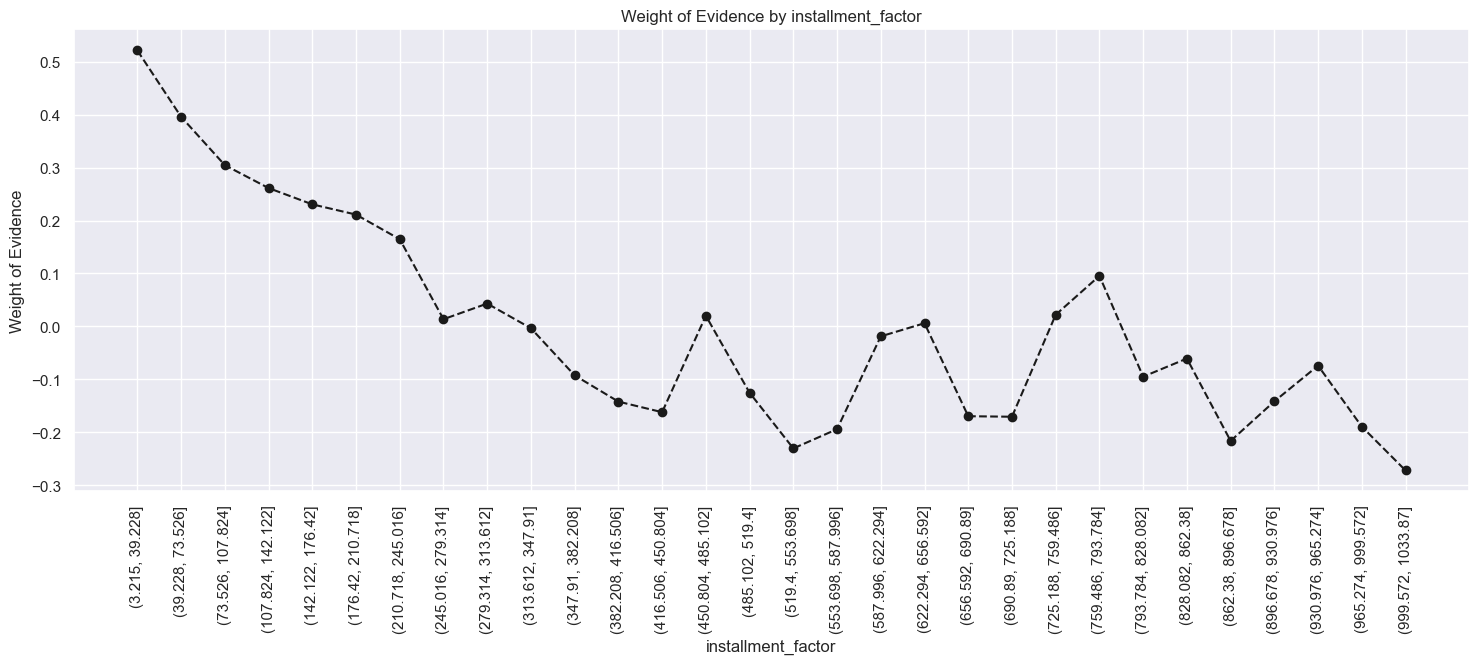

In [24]:
plot_by_woe(iv_per_var_con["installment_factor"][1][:30], rotation_of_x_axis_labels = 90)

### Using the WOE table and plot, we bin the `installment` variable into multiple categories, with WOE decreasing and Probability of default increasing with the increase in `installment` amount. The reference category will be `installment:>1000`.

In [25]:
data_in_use["installment:<142"] = np.where(data_in_use["installment"] <= 142.0, 1, 0)

data_in_use["installment:142-245"] = np.where((data_in_use["installment"] > 142.0) & 
                                                 (data_in_use["installment"] <= 245.0), 1, 0)

data_in_use["installment:245-348"] = np.where((data_in_use["installment"] > 245.0) & 
                                                 (data_in_use["installment"] <= 348.0), 1, 0)

data_in_use["installment:348-451"] = np.where((data_in_use["installment"] > 348.0) & 
                                                 (data_in_use["installment"] <= 451.0), 1, 0)

data_in_use["installment:451-588"] = np.where((data_in_use["installment"] > 451.0) & 
                                                 (data_in_use["installment"] <= 588.0), 1, 0)

data_in_use["installment:588-725"] = np.where((data_in_use["installment"] > 588.0) & 
                                                 (data_in_use["installment"] <= 725.0), 1, 0)

data_in_use["installment:725-897"] = np.where((data_in_use["installment"] > 725.0) & 
                                                 (data_in_use["installment"] <= 897.0), 1, 0)

data_in_use["installment:897-1000"] = np.where((data_in_use["installment"] > 897.0) & 
                                                 (data_in_use["installment"] <= 1000.0), 1, 0)

data_in_use["installment:>1000"] = np.where(data_in_use["installment"] > 1000.0, 1, 0)

### months_since_earliest_cr_line_factor
- The Information Value (IV) is **0.0131**, which is slightly below the 0.02 threshold, so we can remove it if it shows no meaningful relationship.**

In [26]:
iv_per_var_con["months_since_earliest_cr_line_factor"][1]

,months_since_earliest_cr_line_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-1.109, 22.18]",25,1.382335e-05,22.0,3.0,1.391472e-05,0.000013,0.880000,0.053620,3.895285e-08
1,"(22.18, 44.36]",0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(44.36, 66.54]",0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(66.54, 88.72]",0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(88.72, 110.9]",0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"(110.9, 133.08]",9360,5.175463e-03,8992.0,368.0,5.687327e-03,0.001618,0.960684,1.257198,5.116251e-03
6,"(133.08, 155.26]",32223,1.781719e-02,29505.0,2718.0,1.866154e-02,0.011949,0.915650,0.445854,2.993005e-03
7,"(155.26, 177.44]",51767,2.862374e-02,45770.0,5997.0,2.894895e-02,0.026363,0.884154,0.093560,2.419093e-04
8,"(177.44, 199.62]",57657,3.188052e-02,50670.0,6987.0,3.204814e-02,0.030715,0.878818,0.042473,5.660268e-05
9,"(199.62, 221.8]",114813,6.348402e-02,101050.0,13763.0,6.391286e-02,0.060503,0.880127,0.054822,1.869153e-04


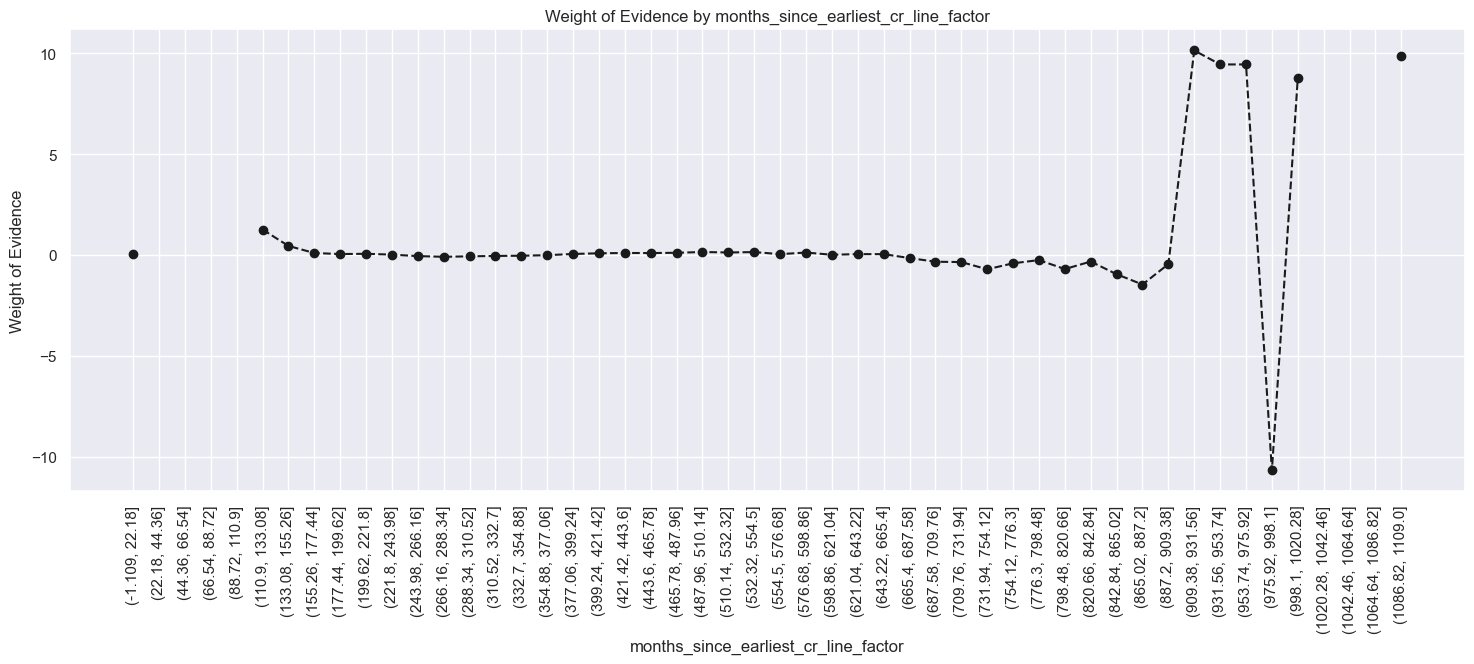

In [27]:
plot_by_woe(iv_per_var_con["months_since_earliest_cr_line_factor"][1], rotation_of_x_axis_labels = 90)

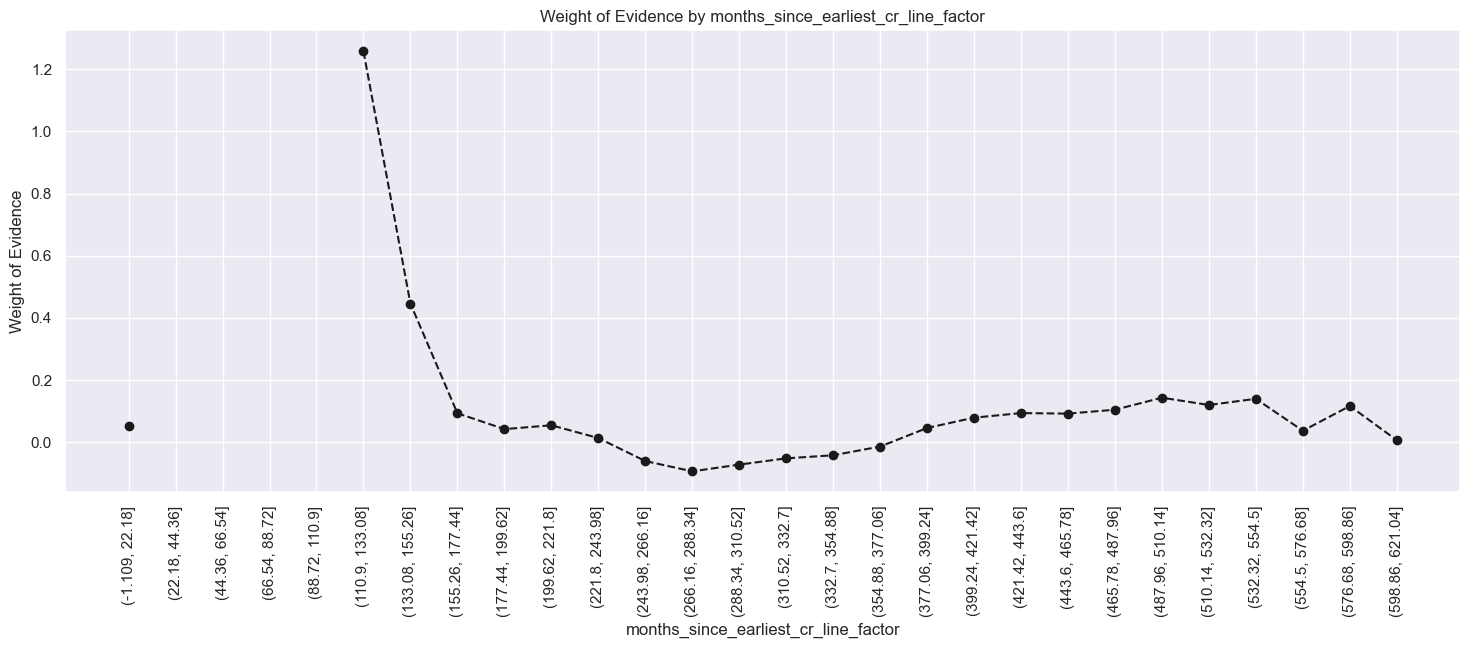

In [28]:
plot_by_woe(iv_per_var_con["months_since_earliest_cr_line_factor"][1][:28], rotation_of_x_axis_labels = 90)

### The Weight of Evidence (WOE) plots for `months_since_earliest_cr_line_factor` exhibit very minimal variation, appearing almost as horizontal lines. This indicates that these variables provide little to no discriminatory power between good and bad cases. Given its low Information Value (IV) and lack of meaningful WOE variation, these variables have been excluded from further modeling to maintain model simplicity and effectiveness.

---
### total_acc_factor

- The Information Value (IV) is **0.0026**, which is below the 0.02 threshold, so we can remove it if it shows no meaningful relationship.**

In [29]:
iv_per_var_con["total_acc_factor"][1]

,total_acc_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-0.176, 3.52]",4475,2.474380e-03,4057.0,418.0,2.566002e-03,0.001838,0.906592,0.333908,2.432308e-04
1,"(3.52, 7.04]",65766,3.636426e-02,58382.0,7384.0,3.692588e-02,0.032461,0.887723,0.128882,5.754819e-04
2,"(7.04, 10.56]",110733,6.122804e-02,97582.0,13151.0,6.171939e-02,0.057813,0.881237,0.065385,2.554246e-04
3,"(10.56, 14.08]",215936,1.193984e-01,189508.0,26428.0,1.198614e-01,0.116180,0.877612,0.031197,1.148573e-04
4,"(14.08, 17.6]",190706,1.054478e-01,167065.0,23641.0,1.056665e-01,0.103928,0.876034,0.016591,2.884475e-05
5,"(17.6, 21.12]",261825,1.447720e-01,229234.0,32591.0,1.449876e-01,0.143273,0.875524,0.011897,2.040088e-05
6,"(21.12, 24.64]",186197,1.029547e-01,162736.0,23461.0,1.029285e-01,0.103137,0.873999,-0.002020,4.204241e-07
7,"(24.64, 28.16]",214983,1.188714e-01,187741.0,27242.0,1.187438e-01,0.119758,0.873283,-0.008506,8.628731e-06
8,"(28.16, 31.68]",131869,7.291486e-02,114929.0,16940.0,7.269115e-02,0.074470,0.871539,-0.024173,4.299329e-05
9,"(31.68, 35.2]",136707,7.558995e-02,119171.0,17536.0,7.537416e-02,0.077090,0.871726,-0.022506,3.861238e-05


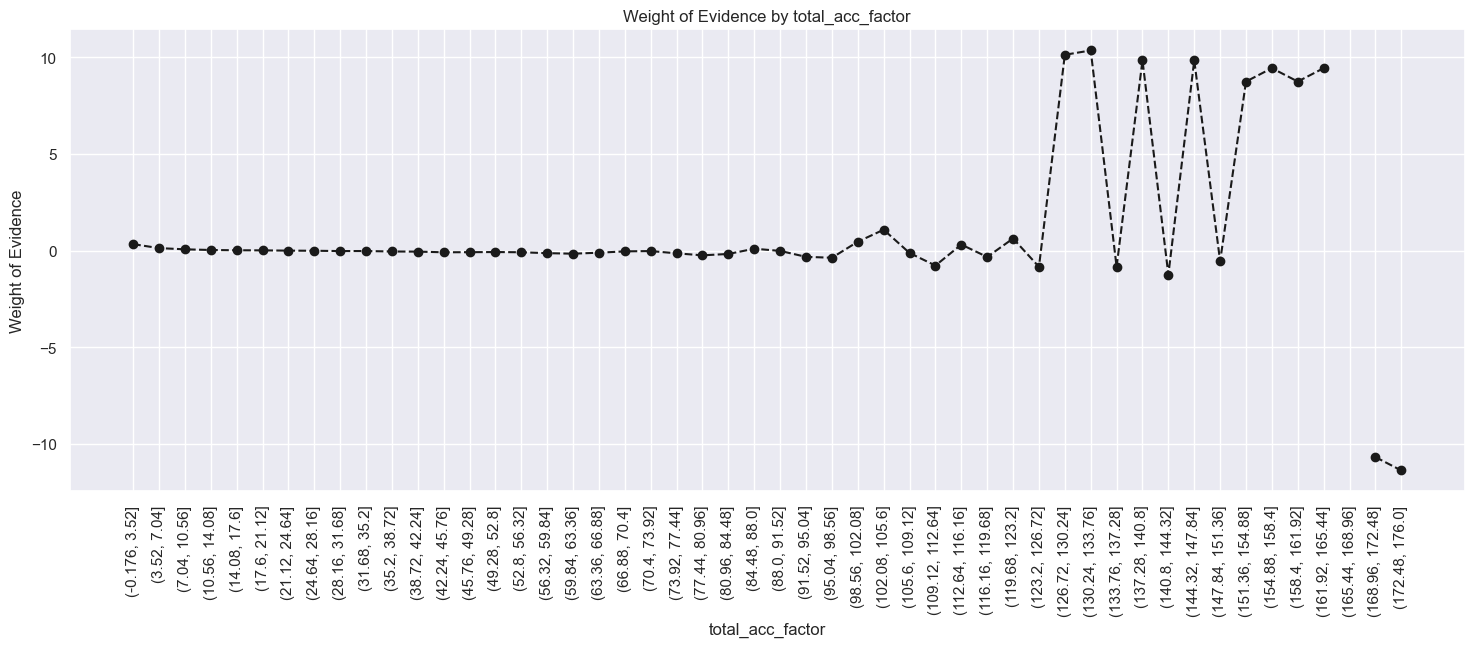

In [30]:
plot_by_woe(iv_per_var_con["total_acc_factor"][1], rotation_of_x_axis_labels = 90)

In [31]:
iv_per_var_con["total_acc_factor"][1][12:]['n_obs'].sum(), iv_per_var_con["total_acc_factor"][1][12:]['prop_obs'].sum() * 100,

(np.int64(138924), np.float64(7.681580772050733))

### This shows only 7.68% of the observations belong to groups 12 - 49. Groups from 12 - 15 had decent number of observations but WOE for those groups were very similar. Groups from 15 - 49 had very less observations, hence, we decide to create a single category (> 42.24) to incorporate observations from group 12 - 49.

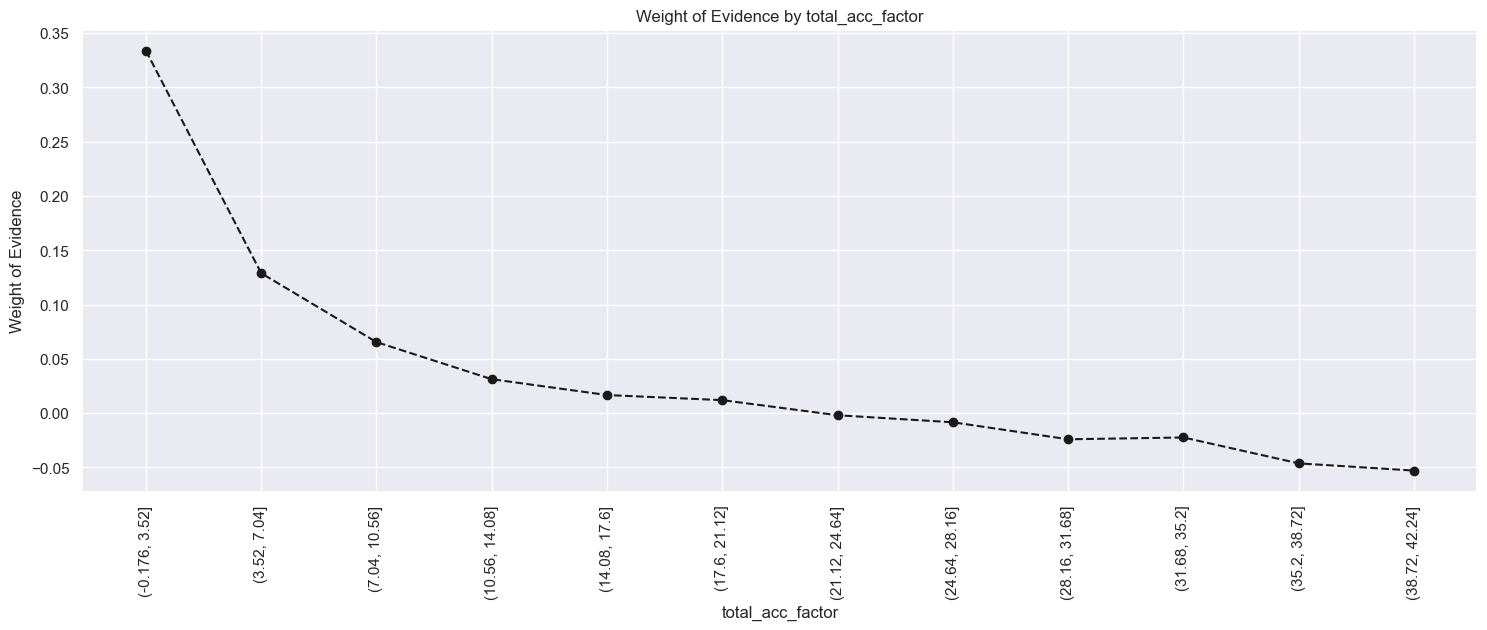

In [32]:
plot_by_woe(iv_per_var_con["total_acc_factor"][1][:12], rotation_of_x_axis_labels = 90)

In [33]:

data_in_use["total_acc:<14.08"] = np.where(data_in_use["total_acc"] < 14.08, 1, 0)


data_in_use["total_acc:14.08-21.12"] = np.where((data_in_use["total_acc"] > 14.08) & 
                                                 (data_in_use["total_acc"] <= 21.12), 1, 0)


data_in_use["total_acc:21.12-31.68"] = np.where((data_in_use["total_acc"] > 21.12) & 
                                                 (data_in_use["total_acc"] <= 31.68), 1, 0)


data_in_use["total_acc:31.68-42.24"] = np.where((data_in_use["total_acc"] > 31.68) & 
                                                 (data_in_use["total_acc"] <= 42.24), 1, 0)

data_in_use["total_acc:>42.24"] = np.where(data_in_use["total_acc"] > 42.24, 1, 0)

### Using the WOE table and plot, we bin the `total_acc` variable into multiple categories, with WOE decreasing and Probability of default increasing with the increase in `total_acc` value. The reference category will be `total_acc:>42.24`.

## Now, we will work with the variables that had less than 100 categories.

>> **Variables with less than 100 categories are:**
>>
> > > inq_last_6mths
> > >
> > > pub_rec
> > >
> > > open_acc
> > >
> > > delinq_2yrs
> > >
> > > acc_now_delinq
> > >

In [34]:
iv_per_var_con = {}
list_of_variables = ["inq_last_6mths","pub_rec", "open_acc", "delinq_2yrs", "acc_now_delinq"] 

# loan_status is not inlcuded as it was used to derive our dependent variable (or True values.)

for var in list_of_variables:
    df_woe, iv_grade = calculate_IV(data_in_use, output_data, var, dtype = "continous")
    iv_per_var_con[var] = [iv_grade, df_woe]

Information Value (IV) for variable inq_last_6mths: 0.0625
Information Value (IV) for variable pub_rec: 0.0119
Information Value (IV) for variable open_acc: 0.0057
Information Value (IV) for variable delinq_2yrs: 0.0046
Information Value (IV) for variable acc_now_delinq: 0.0005


### Information Value (IV) Summary for Selected Variables

- **inq_last_6mths**: 0.0625 — Indicates a weak but potentially useful predictor.
- **pub_rec**: 0.0119 — Very weak predictive power.
- **open_acc**: 0.0057 — Negligible predictive power, can be considered for removal.
- **delinq_2yrs**: 0.0046 — Negligible predictive power, can be considered for removal.
- **acc_now_delinq**: 0.0005 — No predictive power, can be considered for removal.

> **Note:** Variables with IV below 0.02 generally contribute very little to the model and may be excluded or carefully reconsidered depending on business context.

---

## **Analysing WOE of inq_last_6mths**

In [35]:
iv_per_var_con["inq_last_6mths"][1]

,inq_last_6mths,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,0.0,1105429,6.112293e-01,988061.0,117368.0,6.249362e-01,0.515960,0.893826,0.191620,0.020882
1,1.0,467599,2.585514e-01,401167.0,66432.0,2.537331e-01,0.292041,0.857930,-0.140611,0.005386
2,2.0,160153,8.855404e-02,132718.0,27435.0,8.394247e-02,0.120607,0.828695,-0.362403,0.013287
3,3.0,55127,3.048159e-02,43846.0,11281.0,2.773205e-02,0.049592,0.795363,-0.581246,0.012706
4,4.0,13907,7.689654e-03,10564.0,3343.0,6.681598e-03,0.014696,0.759617,-0.788226,0.006317
5,5.0,4957,2.740894e-03,3730.0,1227.0,2.359178e-03,0.005394,0.752471,-0.826974,0.002510
6,6.0,1015,5.612280e-04,749.0,266.0,4.737331e-04,0.001169,0.737931,-0.903567,0.000629
7,7.0,140,7.741076e-05,89.0,51.0,5.629138e-05,0.000224,0.635714,-1.381998,0.000232
8,8.0,94,5.197580e-05,59.0,35.0,3.731676e-05,0.000154,0.627660,-1.416618,0.000165
9,9.0,38,2.101149e-05,23.0,15.0,1.454721e-05,0.000066,0.605263,-1.511360,0.000078


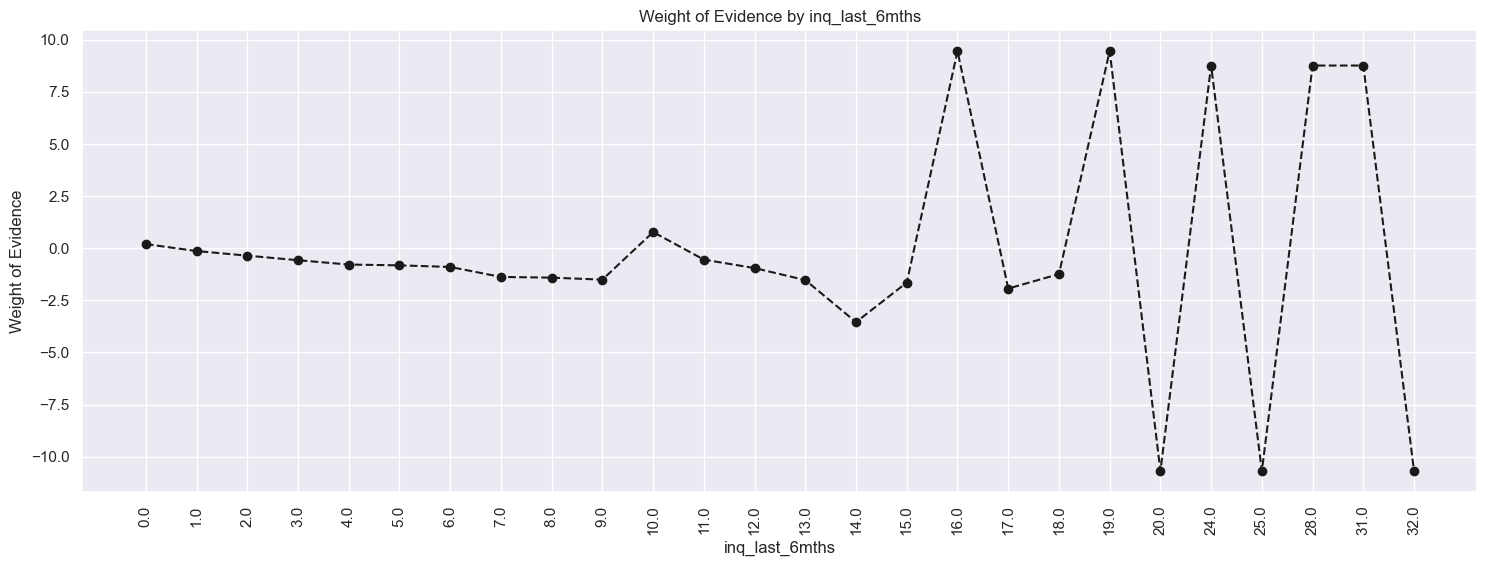

In [36]:
plot_by_woe(iv_per_var_con["inq_last_6mths"][1], rotation_of_x_axis_labels = 90)

### 🧮 Category Consolidation Based on WOE Table

From the WOE table, it is evident that the **majority of observations are concentrated in the first three categories**:

- The **first category** alone contains more than **61%** of the total observations.
- The **second category** holds around **25.85%**, and
- The **third category** contains about **8.85%** of the data.
- The **fourth category** contains about **3.04%** of the data.

Given this highly imbalanced distribution:

- We will **retain the first three categories as separate groups** since they account for a significant portion of the data and likely have meaningful predictive power.
- The **fourth category and the remaining sparse categories** (each contributing less than 1%) will be **merged into a single group**. These lower-volume categories typically have insufficient representation and do not offer substantial discriminatory power on their own.

This grouping helps ensure better **model generalization**, **reduced noise**, and **simplified interpretation**.

In [37]:
data_in_use['inq_last_6mths:0'] = np.where(data_in_use["inq_last_6mths"] == 0.0, 1, 0)

data_in_use['inq_last_6mths:1'] = np.where(data_in_use["inq_last_6mths"] == 1.0, 1, 0)

data_in_use['inq_last_6mths:2'] = np.where(data_in_use["inq_last_6mths"] == 2.0, 1, 0)

data_in_use['inq_last_6mths:>2'] = np.where(data_in_use["inq_last_6mths"] > 2.0, 1, 0)

>>
### **Analysing WOE of pub_rec**

In [38]:
iv_per_var_con["pub_rec"][1]

,pub_rec,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,0.0,1522189,8.416701e-01,1338531.0,183658.0,8.466041e-01,0.807377,0.879346,0.047443,1.861063e-03
1,1.0,244192,1.350221e-01,207723.0,36469.0,1.313822e-01,0.160321,0.850654,-0.199067,5.760742e-03
2,2.0,27521,1.521730e-02,22627.0,4894.0,1.431129e-02,0.021514,0.822172,-0.407676,2.936554e-03
3,3.0,8425,4.658469e-03,7022.0,1403.0,4.441327e-03,0.006168,0.833472,-0.328375,5.669005e-04
4,4.0,3070,1.697507e-03,2529.0,541.0,1.599561e-03,0.002378,0.823779,-0.396650,3.088802e-04
5,5.0,1479,8.177894e-04,1237.0,242.0,7.823870e-04,0.001064,0.836376,-0.307303,8.649544e-05
6,6.0,748,4.135947e-04,621.0,127.0,3.927747e-04,0.000558,0.830214,-0.351666,5.821067e-05
7,7.0,346,1.913152e-04,291.0,55.0,1.840539e-04,0.000242,0.841040,-0.272820,1.575014e-05
8,8.0,194,1.072692e-04,166.0,28.0,1.049929e-04,0.000123,0.855670,-0.159026,2.877985e-06
9,9.0,114,6.303448e-05,98.0,16.0,6.198377e-05,0.000070,0.859649,-0.126431,1.056156e-06


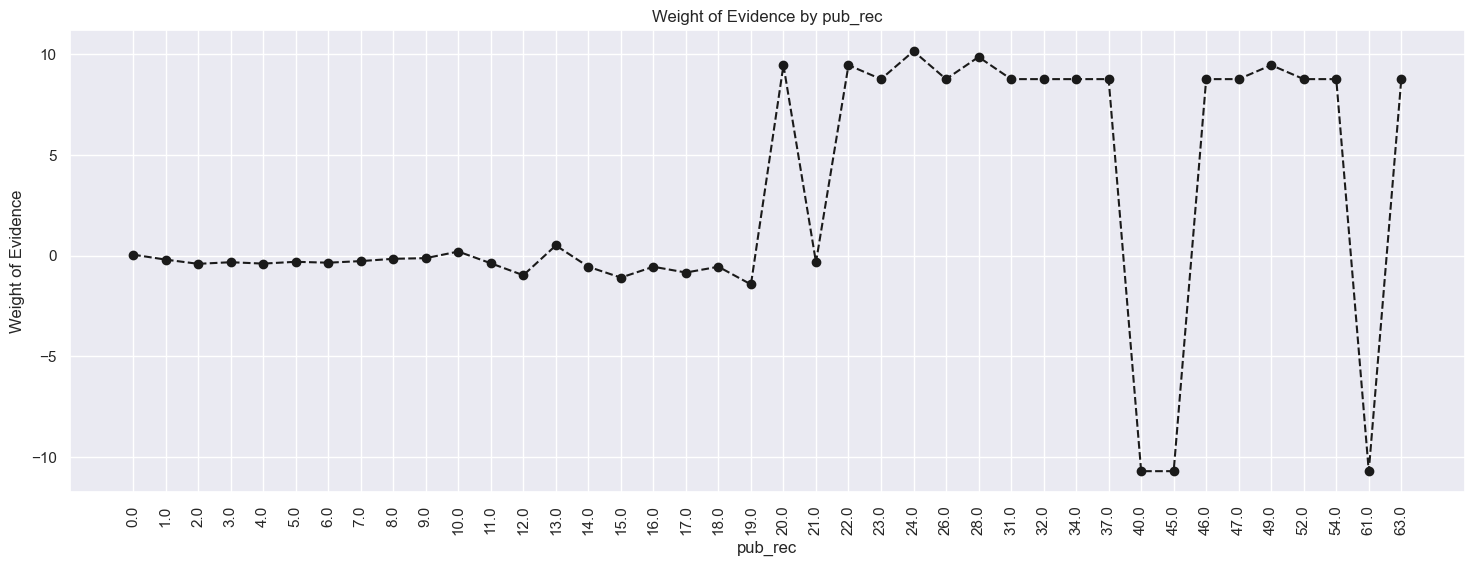

In [39]:
plot_by_woe(iv_per_var_con["pub_rec"][1], rotation_of_x_axis_labels = 90)

### 🧮 Category Consolidation Based on WOE Table

From the WOE table, it is evident that the **majority of observations are concentrated in the first two categories**:

- The **first category** alone contains more than **84.16%** of the total observations.
- The **second category** holds around **13.5%**, and

Given this highly imbalanced distribution:

- We will **retain the first two categories as separate groups** since they account for a significant portion of the data and likely have meaningful predictive power.
  
- The **third category and the remaining sparse categories** (each contributing less than 1%) will be **merged into a single group**. These lower-volume categories typically have insufficient representation and do not offer substantial discriminatory power on their own.

In [40]:
data_in_use['pub_rec:0'] = np.where(data_in_use["pub_rec"] == 0.0, 1, 0)

data_in_use['pub_rec:1'] = np.where(data_in_use["pub_rec"] == 1.0, 1, 0)

data_in_use['pub_rec:>1'] = np.where(data_in_use["pub_rec"] > 1.0, 1, 0)

### WOE plots of variable with very small IV values, and hence not inlcuded.

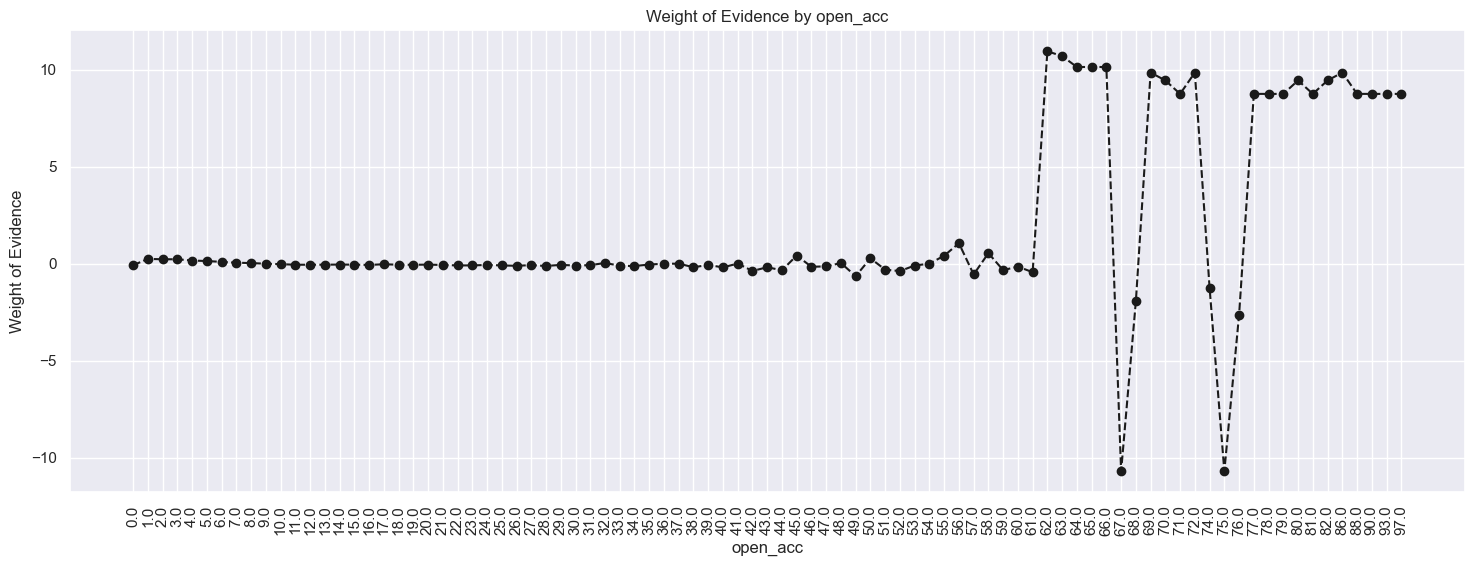

In [41]:
plot_by_woe(iv_per_var_con["open_acc"][1], rotation_of_x_axis_labels = 90)

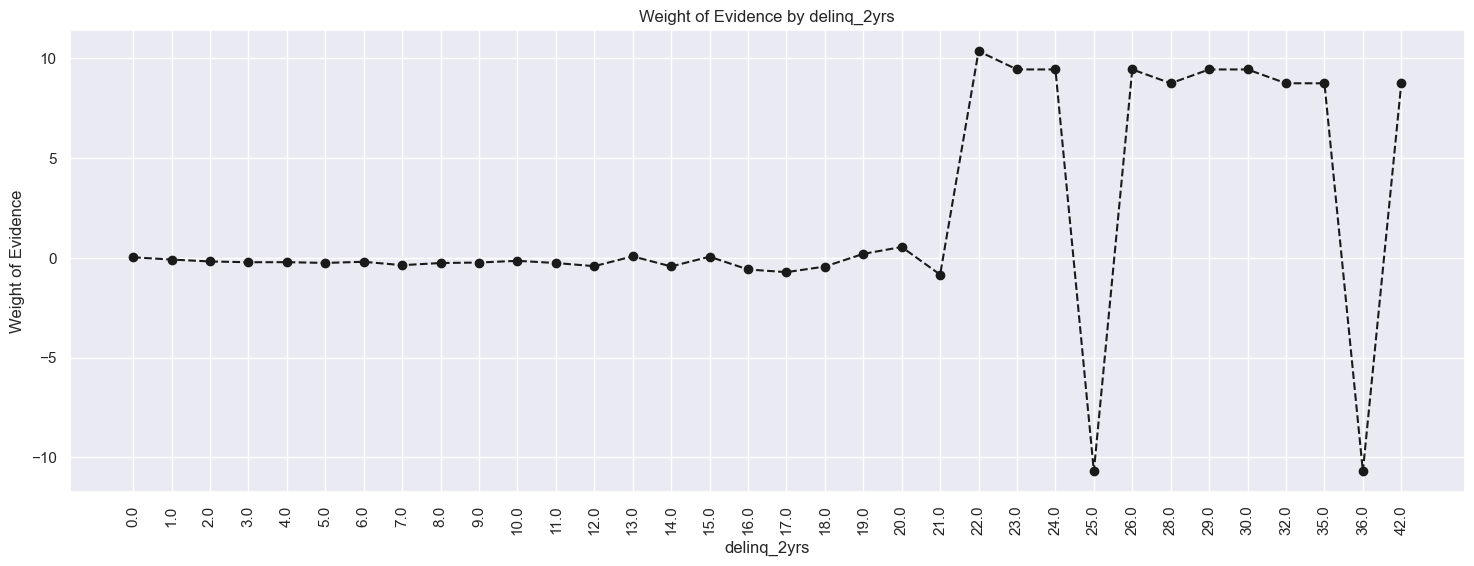

In [42]:
plot_by_woe(iv_per_var_con["delinq_2yrs"][1], rotation_of_x_axis_labels = 90)

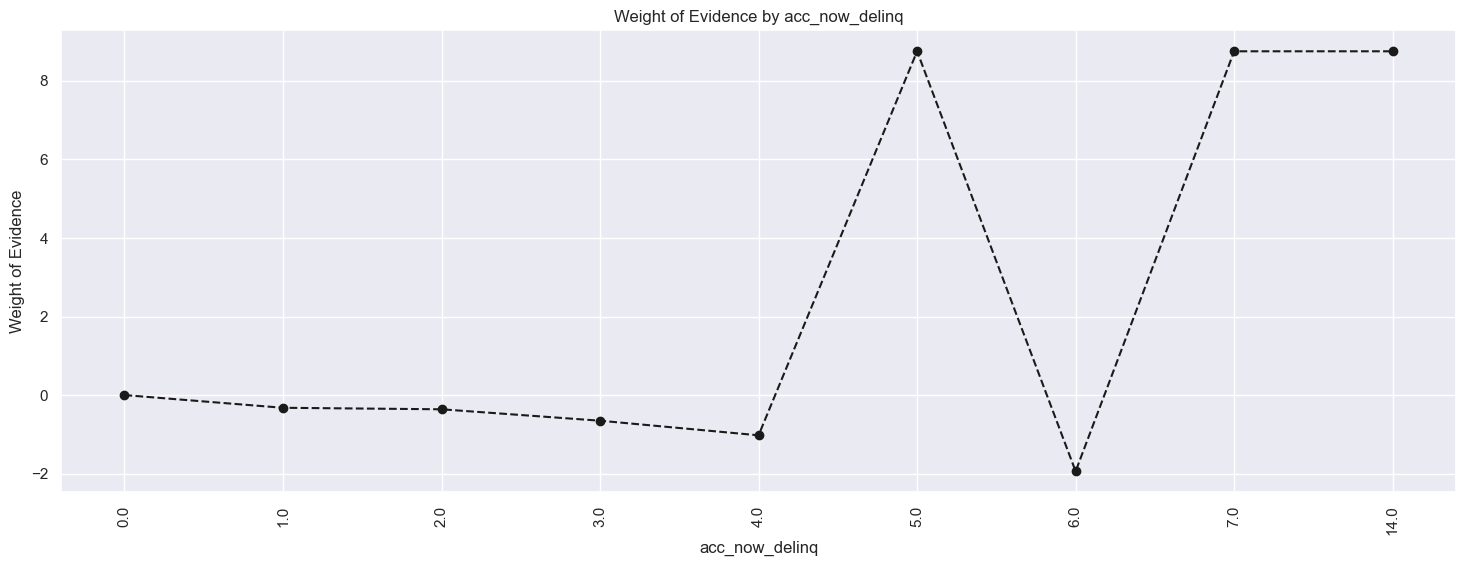

In [43]:
plot_by_woe(iv_per_var_con["acc_now_delinq"][1], rotation_of_x_axis_labels = 90)

---
### **annual_inc**

In [44]:
data_in_use["annual_inc"].isnull().sum() # no missing values()

np.int64(0)

In [45]:
data_in_use["annual_inc"].unique() # a total of 77639 distinct values.

array([140000.  ,  30000.  ,  22848.38, ...,  51253.  , 188295.  ,
        18956.  ], shape=(77639,))

### Starting with the strategy of binning categories using `pd.cut()`

In [46]:
data_in_use["annual_inc_factor"] = pd.cut(data_in_use["annual_inc"], 50)

In [47]:
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "annual_inc_factor", dtype = "continous")

Information Value (IV) for variable annual_inc_factor: 0.0002


In [48]:
df_woe

,annual_inc_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-61000.0, 1220000.0]",1808218,9.998253e-01,1580771.0,227447.0,9.998178e-01,0.999877,0.874215,-0.000059,3.489318e-09
1,"(1220000.0, 2440000.0]",170,9.399879e-05,160.0,10.0,1.011980e-04,0.000044,0.941176,0.833778,4.772303e-05
2,"(2440000.0, 3660000.0]",33,1.824682e-05,26.0,7.0,1.644467e-05,0.000031,0.787879,-0.626621,8.978181e-06
3,"(3660000.0, 4880000.0]",35,1.935269e-05,32.0,3.0,2.023960e-05,0.000013,0.914286,0.428311,3.020166e-06
4,"(4880000.0, 6100000.0]",27,1.492922e-05,24.0,3.0,1.517970e-05,0.000013,0.888889,0.140631,2.800572e-07
5,"(6100000.0, 7320000.0]",21,1.161161e-05,20.0,1.0,1.264975e-05,0.000004,0.952381,1.056908,8.723358e-06
6,"(7320000.0, 8540000.0]",15,8.294011e-06,15.0,0.0,9.487312e-06,0.000000,1.000000,11.460306,1.087275e-04
7,"(8540000.0, 9760000.0]",12,6.635208e-06,8.0,4.0,5.059900e-06,0.000018,0.666667,-1.245649,1.560106e-05
8,"(9760000.0, 10980000.0]",1,5.529340e-07,1.0,0.0,6.324875e-07,0.000000,1.000000,8.752404,5.535786e-06
9,"(10980000.0, 12200000.0]",1,5.529340e-07,1.0,0.0,6.324875e-07,0.000000,1.000000,8.752404,5.535786e-06


### ℹ️ Observation on `annual_inc` Binning into 50 categories:

- From the WOE table, it is evident that **99.98% of the total observations** fall into the **first category**.

- This indicates that using **50 bins** for the variable `annual_inc` was **not sufficient** to effectively separate the distribution. As a result, the binning failed to capture the variability within the income variable, and a more refined or alternative binning strategy is required.

In [49]:
data_in_use["annual_inc_factor"] = pd.cut(data_in_use["annual_inc"], 2500) # 2500 is from random testing.

In [50]:
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "annual_inc_factor", dtype = "continous")

Information Value (IV) for variable annual_inc_factor: 0.0343


In [51]:
df_woe[:10]

,annual_inc_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-61000.0, 24400.0]",58862,0.032547,50305.0,8557.0,0.031817,0.037617,0.854626,-0.167455,0.000971
1,"(24400.0, 48800.0]",439079,0.242782,374296.0,64783.0,0.236738,0.284792,0.852457,-0.184806,0.008881
2,"(48800.0, 73200.0]",559506,0.309370,485137.0,74369.0,0.306843,0.326933,0.867081,-0.063418,0.001274
3,"(73200.0, 97600.0]",342435,0.189344,302243.0,40192.0,0.191165,0.176688,0.882629,0.078754,0.001140
4,"(97600.0, 122000.0]",193637,0.107068,173413.0,20224.0,0.109682,0.088906,0.895557,0.209996,0.004363
5,"(122000.0, 146400.0]",85443,0.047244,77274.0,8169.0,0.048875,0.035912,0.904392,0.308201,0.003995
6,"(146400.0, 170800.0]",52706,0.029143,47907.0,4799.0,0.030301,0.021097,0.908948,0.362044,0.003332
7,"(170800.0, 195200.0]",25051,0.013852,22855.0,2196.0,0.014456,0.009654,0.912339,0.403723,0.001939
8,"(195200.0, 219600.0]",15703,0.008683,14383.0,1320.0,0.009097,0.005803,0.915940,0.449605,0.001481
9,"(219600.0, 244000.0]",9899,0.005473,9056.0,843.0,0.005728,0.003706,0.914840,0.435406,0.000880


In [52]:
df_woe['prop_obs'][:8].sum()

np.float64(0.9713497230353424)

### ℹ️ Observation on `annual_inc` Binning into 100 Categories:

- Once again, the **first bin holds approximately 99.90%** of the total observations.  
- This distribution aligns with real-world expectations — **most borrowers have relatively low annual incomes**, while only a small fraction earn significantly more.
- Specifically, **97.13% of the observations have annual incomes less than 195,200.0**.
- So, considering 200,000 $ in income, as the threshold for a person to be considered High Networking Individual (HNI).

📌 **Action**:  
To simplify and capture this skewed distribution effectively, we can create a **binary variable** indicating whether an individual has an annual income **greater than 200,000**. This approach maintains interpretability and preserves the meaningful separation between common and rare income levels.

In [53]:
data_in_use["annual_inc:>200000"] = np.where(data_in_use["annual_inc"] > 200000.0, 1, 0)

---
## 🎯 Focused Analysis on Income Below $200,000

- Given that we have already created a separate variable to flag individuals with annual income over 200,000. We can now proceed to analyze the remaining population, those earning **less than 200,000**.  

- This segmentation allows us to better understand income-related patterns within the more common income ranges,  
without being skewed by high-income outliers.

In [54]:
# creating a temp dataframe for analyses.

inp_data_temp = data_in_use.loc[data_in_use["annual_inc"] <=200000, :]

df_woe["n_obs"].sum() == data_in_use["annual_inc:>200000"].sum() + len(inp_data_temp)

# total obs equals the number of observations with income less than 200k + the number of observations with income more than 200k. 

np.True_

In [55]:
inp_data_temp['annual_inc_factor'] = pd.cut(inp_data_temp["annual_inc"], 50) # again starting with 50.

out_data_temp = output_data.loc[inp_data_temp.index]

In [56]:
df_woe, iv_grade = calculate_IV(inp_data_temp, out_data_temp, "annual_inc_factor", dtype = "continous")

Information Value (IV) for variable annual_inc_factor: 0.0300


In [57]:
df_woe

,annual_inc_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-200.0, 4000.0]",1826,0.001034,1723.0,103.0,0.001118,0.000460,0.943593,0.888406,0.000584
1,"(4000.0, 8000.0]",867,0.000491,805.0,62.0,0.000522,0.000277,0.928489,0.635021,0.000156
2,"(8000.0, 12000.0]",5001,0.002832,4296.0,705.0,0.002786,0.003146,0.859028,-0.121445,0.000044
3,"(12000.0, 16000.0]",9422,0.005336,8036.0,1386.0,0.005212,0.006185,0.852897,-0.171177,0.000167
4,"(16000.0, 20000.0]",17233,0.009759,14647.0,2586.0,0.009500,0.011541,0.849939,-0.194564,0.000397
5,"(20000.0, 24000.0]",23972,0.013575,20359.0,3613.0,0.013205,0.016124,0.849282,-0.199702,0.000583
6,"(24000.0, 28000.0]",40457,0.022911,34183.0,6274.0,0.022171,0.027999,0.844922,-0.233373,0.001360
7,"(28000.0, 32000.0]",62034,0.035130,52626.0,9408.0,0.034134,0.041985,0.848341,-0.207037,0.001626
8,"(32000.0, 36000.0]",74219,0.042030,63076.0,11143.0,0.040912,0.049728,0.849863,-0.195158,0.001721
9,"(36000.0, 40000.0]",93644,0.053031,80006.0,13638.0,0.051893,0.060863,0.854363,-0.159445,0.001430


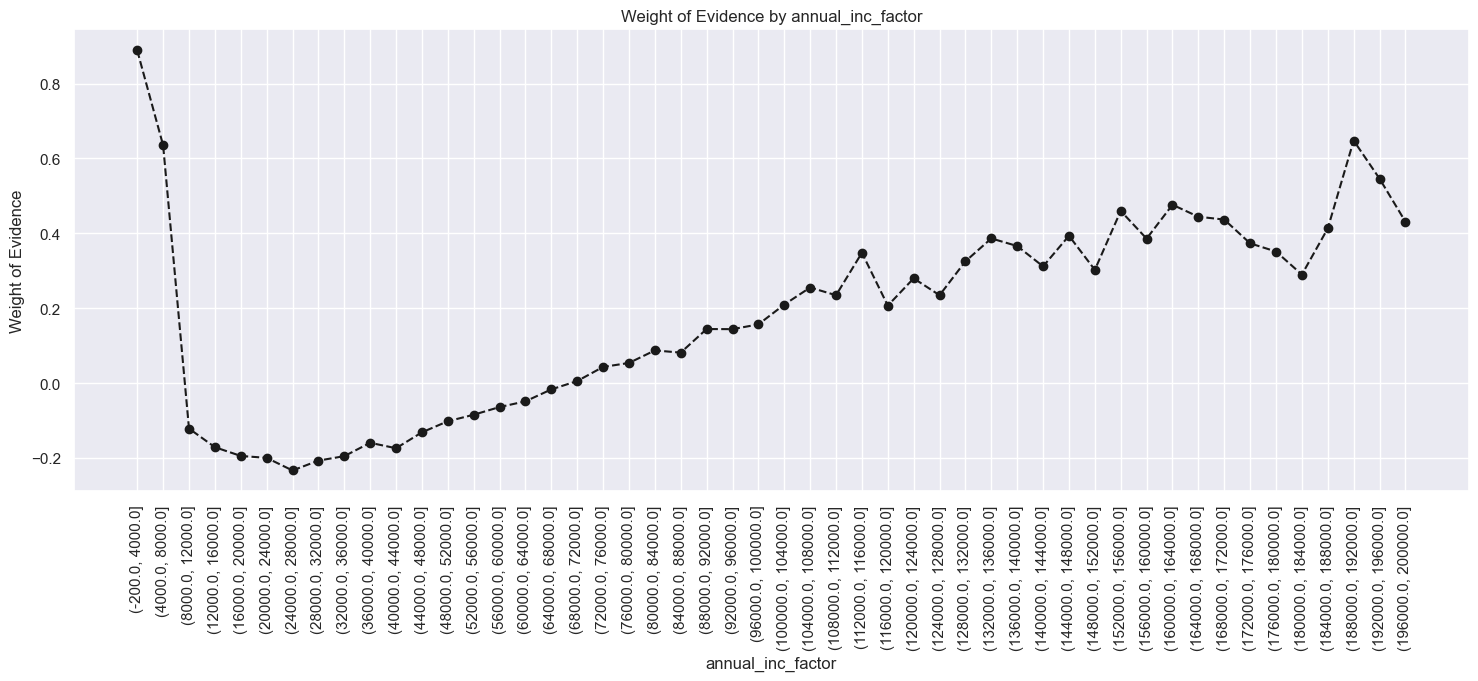

In [58]:
plot_by_woe(df_woe, rotation_of_x_axis_labels = 90)

- ### 📊 Binning Strategy for `annual_inc`

The binning of the `annual_inc` variable was driven by a combination of **Weight of Evidence (WOE) patterns** and the **distribution of observations** across income ranges.

#### Key Considerations:

- **WOE Trend**: From the WOE plot, it is evident that as the `annual_inc` increases, the WOE also increases. This indicates that the probability of default (PD) decreases with increasing income—higher income groups are less risky. 
- **Early Income Bins**: The first two income bins (`<=4000` and `4000–8000`) have **very low observation counts** and relatively **high WOE values**, making them outliers. Due to the limited data in these bins, they were **merged** with the next bracket (`<=24000`) for stability.
- **Middle Income Bins**: Between `24,000` and `100,000`, WOE values are generally negative and vary moderately. These ranges contain **large portions of the dataset**, so the bins were kept **narrow and granular** to preserve signal.
- **Higher Income Bins**: From `100,000` to `200,000`, WOE values steadily increase and even become **strongly positive**. However, some of these bins have fewer observations, so we carefully grouped bins to **balance WOE stability and sample size**.

#### Final Bins:

- `<=24,000`  
- `24,000–36,000`  
- `36,000–48,000`  
- `48,000–60,000`  
- `60,000–72,000`  
- `72,000–88,000`  
- `88,000–100,000`  
- `100,000–116,000`  
- `116,000–128,000`  
- `128,000–152,000`  
- `152,000–200,000`
- `>200,000` (created initially)

Each bin was designed to ensure:
- A reasonably **stable WOE value** within the bin,  
- An adequate **number of observations** to avoid noise,  
- Preservation of the **monotonic relationship** between income and risk.

This approach provides a good balance between interpretability, predictive power, and model robustness.



In [59]:
data_in_use["annual_inc:<24000"] = np.where(data_in_use["annual_inc"] <= 24000.0, 1, 0)

data_in_use["annual_inc:24000-36000"] = np.where((data_in_use["annual_inc"] > 24000.0) & 
                                                 (data_in_use["annual_inc"] <= 36000.0), 1, 0)

data_in_use["annual_inc:36000-48000"] = np.where((data_in_use["annual_inc"] > 36000.0) & 
                                                 (data_in_use["annual_inc"] <= 48000.0), 1, 0)

data_in_use["annual_inc:48000-60000"] = np.where((data_in_use["annual_inc"] > 48000.0) & 
                                                 (data_in_use["annual_inc"] <= 60000.0), 1, 0)

data_in_use["annual_inc:60000-72000"] = np.where((data_in_use["annual_inc"] > 60000.0) & 
                                                 (data_in_use["annual_inc"] <= 72000.0), 1, 0)

data_in_use["annual_inc:72000-88000"] = np.where((data_in_use["annual_inc"] > 72000.0) & 
                                                 (data_in_use["annual_inc"] <= 88000.0), 1, 0)

data_in_use["annual_inc:88000-100000"] = np.where((data_in_use["annual_inc"] > 88000.0) & 
                                                 (data_in_use["annual_inc"] <= 100000.0), 1, 0)

data_in_use["annual_inc:100000-116000"] = np.where((data_in_use["annual_inc"] > 100000.0) & 
                                                 (data_in_use["annual_inc"] <= 116000.0), 1, 0)

data_in_use["annual_inc:116000-128000"] = np.where((data_in_use["annual_inc"] > 116000.0) & 
                                                 (data_in_use["annual_inc"] <= 128000.0), 1, 0)

data_in_use["annual_inc:128000-152000"] = np.where((data_in_use["annual_inc"] > 128000.0) & 
                                                 (data_in_use["annual_inc"] <= 152000.0), 1, 0)

data_in_use["annual_inc:152000-200000"] = np.where((data_in_use["annual_inc"] > 152000.0) & 
                                                 (data_in_use["annual_inc"] <= 200000.0), 1, 0)

---

### 💳 `dti` (Debt-to-Income Ratio)

The `dti` variable stands for **Debt-to-Income Ratio**. It is a key indicator used by lenders to assess a borrower's ability to manage monthly debt payments in relation to their income.

---

#### 📌 What it represents:
- The percentage of a borrower's **gross monthly income** that goes toward paying off **existing debts** (such as credit card payments, mortgages, car loans, etc.).
- It helps lenders evaluate how **financially stretched** a borrower might be.

---

#### 📊 Interpretation:
| DTI Range | Interpretation |
|-----------|----------------|
| **0% – 20%** | Healthy — low debt burden |
| **20% – 35%** | Moderate — manageable debt |
| **Above 35%** | High — potentially risky borrower |

---

#### 🚨 Why DTI matters:
- A **high DTI** suggests the borrower is spending a large portion of income on debt, which may reduce their capacity to repay new loans.
- A **low DTI** indicates better financial stability and is generally preferred by lenders.


In [60]:
data_in_use["dti"].isnull().sum() # 1357 missing values()

np.int64(1357)

In [61]:
null_dti_rows = data_in_use[data_in_use["dti"].isna()]
null_dti_rows #[['funded_amnt', 'dti', 'installment']]

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,annual_inc:24000-36000,annual_inc:36000-48000,annual_inc:48000-60000,annual_inc:60000-72000,annual_inc:72000-88000,annual_inc:88000-100000,annual_inc:100000-116000,annual_inc:116000-128000,annual_inc:128000-152000,annual_inc:152000-200000
2106,28800,60 months,20.89,777.36,D,D4,NaN,NaN,MORTGAGE,0.0,...,0,0,0,0,0,0,0,0,0,0
3718,10000,60 months,19.92,264.50,D,D3,NaN,NaN,RENT,0.0,...,0,0,0,0,0,0,0,0,0,0
6415,28000,36 months,22.35,1074.41,D,D5,NaN,NaN,OWN,0.0,...,0,0,0,0,0,0,0,0,0,0
7145,21000,60 months,19.42,549.62,D,D3,NaN,NaN,MORTGAGE,0.0,...,0,0,0,0,0,0,0,0,0,0
7817,17500,60 months,19.03,454.25,D,D3,NaN,NaN,MORTGAGE,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797299,11400,60 months,17.47,286.21,D,D1,NaN,NaN,MORTGAGE,0.0,...,0,0,0,0,0,0,0,0,0,0
1798390,30000,60 months,15.04,714.33,C,C4,NaN,NaN,MORTGAGE,0.0,...,0,0,0,0,0,0,0,0,0,0
1801590,31700,60 months,30.79,1041.04,G,G1,NaN,NaN,RENT,0.0,...,0,0,0,0,0,0,0,0,0,0
1804586,11200,36 months,15.05,388.53,C,C4,NaN,NaN,RENT,0.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# filling the missing values by median of the dti.

median_dti = data_in_use['dti'].median()
data_in_use['dti'] = data_in_use['dti'].fillna(median_dti)
data_in_use["dti"].isnull().sum() 

np.int64(0)

In [63]:
len(data_in_use["dti"].unique())

10225

### `dti` have a total of 10225 distinct values. Lets start with creating 50 categories.

In [64]:
data_in_use['dti_factor'] = pd.cut(data_in_use["dti"], 50) # again starting with 50.
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "dti_factor", dtype = "continous")

Information Value (IV) for variable dti_factor: 0.0356


In [65]:
df_woe['prop_obs'][:3].sum()

np.float64(0.9961383087074945)

### ℹ️ Observation on Variable Binning:

- The Information Value (IV) is **0.0356**, which indicates **weak predictive power**, but the variable can still be considered for modeling.
- From the WOE table above, it is evident that approximately **99% of the observations** lie within the **first three categories**.
- This skew suggests that the current binning is not optimal. Therefore, we should consider **merging or redefining** the bins to ensure a more balanced distribution of observations across categories, while preserving WOE separation.


In [66]:
data_in_use['dti_factor'] = pd.cut(data_in_use["dti"], 100) 
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "dti_factor", dtype = "continous")

Information Value (IV) for variable dti_factor: 0.0439


In [67]:
df_woe['prop_obs'][:4].sum()

np.float64(0.9844365657488332)

In [68]:
data_in_use['dti_factor'] = pd.cut(data_in_use["dti"], 1000) 
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "dti_factor", dtype = "continous")

Information Value (IV) for variable dti_factor: 0.0555


In [69]:
df_woe['prop_obs'][:41].sum() 

np.float64(0.9879698142252232)

### This shows that 98.79% of the observations are now divided between the first 41 categories and the rest 1.21% is distributed in the remaining 959 categories. Now, we can simply merge them and create a single dummy variable.

In [70]:
df_woe[:41]

,dti_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-2.0, 0.0]",1363,0.000754,1215.0,148.0,0.000768,0.000651,0.891416,0.166477,1.961956e-05
1,"(0.0, 1.0]",7807,0.004317,7032.0,775.0,0.004448,0.003407,0.900730,0.266554,2.773981e-04
2,"(1.0, 2.0]",13172,0.007283,11850.0,1322.0,0.007495,0.005812,0.899636,0.254372,4.281973e-04
3,"(2.0, 3.0]",17879,0.009886,16200.0,1679.0,0.010246,0.007381,0.906091,0.328003,9.398160e-04
4,"(3.0, 4.0]",23485,0.012986,21290.0,2195.0,0.013466,0.009649,0.906536,0.333246,1.271747e-03
5,"(4.0, 5.0]",29007,0.016039,26312.0,2695.0,0.016642,0.011847,0.907091,0.339817,1.629272e-03
6,"(5.0, 6.0]",35060,0.019386,31739.0,3321.0,0.020075,0.014599,0.905277,0.318470,1.743662e-03
7,"(6.0, 7.0]",40784,0.022551,36841.0,3943.0,0.023301,0.017334,0.903320,0.295860,1.765601e-03
8,"(7.0, 8.0]",46965,0.025969,42476.0,4489.0,0.026866,0.019734,0.904418,0.308499,2.200064e-03
9,"(8.0, 9.0]",52993,0.029302,47858.0,5135.0,0.030270,0.022574,0.903100,0.293349,2.257516e-03


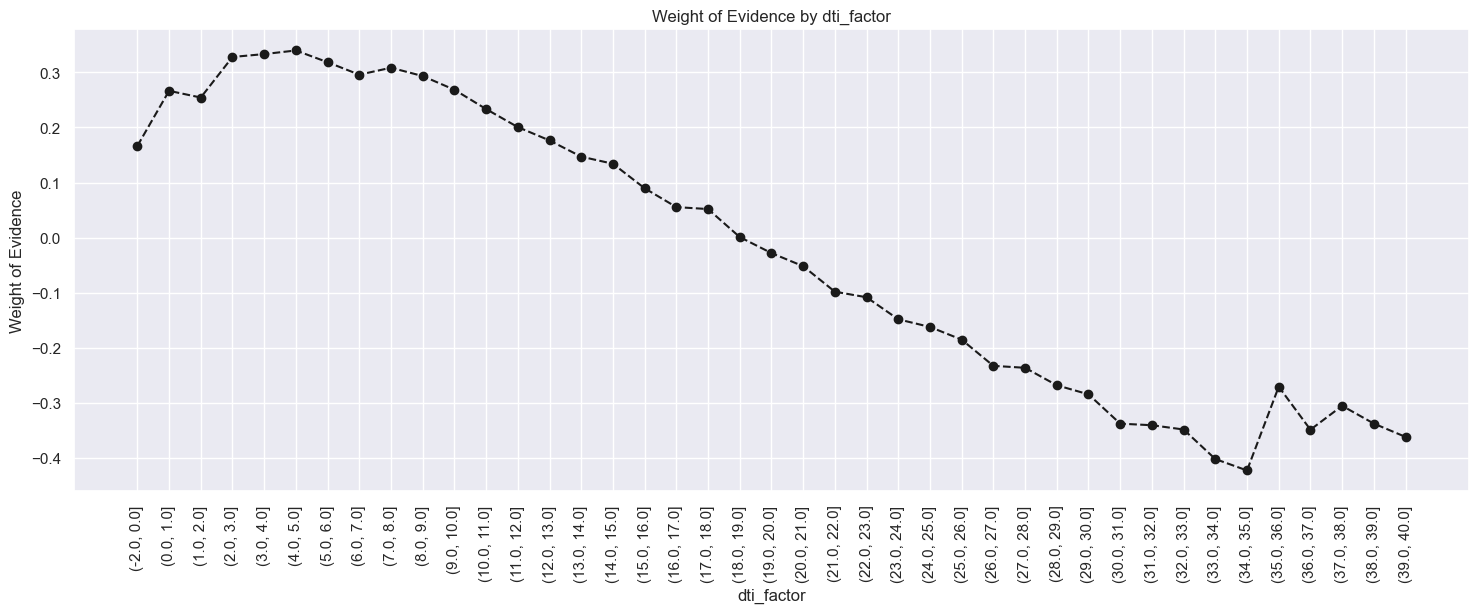

In [71]:
plot_by_woe(df_woe[:41], rotation_of_x_axis_labels = 90)

### 📉 Observation on `dti` from the WOE Plot

From the WOE plot of the variable `dti`, it is clear that, **with the exception of the initial few groups**, as `dti` increases, **WOE decreases**, indicating an **increase in the probability of default (PD)**.

However, it's important to note that these initial groups contain a **less number of observations** compared to the rest. Therefore, for modeling efficiency and stability, we can **safely merge the initial low-volume groups** into a single category.

In [72]:
data_in_use["dti:<3"] = np.where(data_in_use["dti"] <= 3.0, 1, 0)

data_in_use["dti:3-6"] = np.where((data_in_use["dti"] > 3.0) & (data_in_use["dti"] <= 6.0), 1, 0)

data_in_use["dti:6-9"] = np.where((data_in_use["dti"] > 6.0) & (data_in_use["dti"] <= 9.0), 1, 0)

data_in_use["dti:9-12"] = np.where((data_in_use["dti"] > 9.0) & (data_in_use["dti"] <= 12.0), 1, 0)

data_in_use["dti:12-15"] = np.where((data_in_use["dti"] > 12.0) & (data_in_use["dti"] <= 15.0), 1, 0)

data_in_use["dti:15-18"] = np.where((data_in_use["dti"] > 15.0) & (data_in_use["dti"] <= 18.0), 1, 0)

data_in_use["dti:18-21"] = np.where((data_in_use["dti"] > 18.0) & (data_in_use["dti"] <= 21.0), 1, 0)

data_in_use["dti:21-23"] = np.where((data_in_use["dti"] > 21.0) & (data_in_use["dti"] <= 23.0), 1, 0)

data_in_use["dti:23-26"] = np.where((data_in_use["dti"] > 23.0) & (data_in_use["dti"] <= 26.0), 1, 0)

data_in_use["dti:26-30"] = np.where((data_in_use["dti"] > 26.0) & (data_in_use["dti"] <= 30.0), 1, 0)

data_in_use["dti:30-35"] = np.where((data_in_use["dti"] > 30.0) & (data_in_use["dti"] <= 35.0), 1, 0)

data_in_use["dti:>35"] = np.where(data_in_use["dti"] > 35.0, 1, 0)

In [73]:
# This gives us the distribution of number of observations in each bin.

pd.cut(data_in_use["dti"], bins=[-float("inf"),3,6,9,12,15,18,21,23,26,30,35,float("inf")]).value_counts()

dti
(15.0, 18.0]    233325
(12.0, 15.0]    224766
(18.0, 21.0]    218274
(9.0, 12.0]     191885
(26.0, 30.0]    174370
(23.0, 26.0]    169899
(6.0, 9.0]      140742
(21.0, 23.0]    131499
(30.0, 35.0]    129748
(3.0, 6.0]       87552
(35.0, inf]      66253
(-inf, 3.0]      40221
Name: count, dtype: int64

In [74]:
data_in_use['dti_factor'] = pd.cut(data_in_use["dti"], bins=[-float("inf"),3,6,9,12,15,18,21,23,26,30,35,float("inf")])
df_woe, iv_grade = calculate_IV(data_in_use, output_data, "dti_factor", dtype = "continous")

Information Value (IV) for variable dti_factor: 0.0430


In [75]:
df_woe

,dti_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-inf, 3.0]",40221,0.022240,36297.0,3924.0,0.022957,0.017250,0.902439,0.285814,0.001631
1,"(3.0, 6.0]",87552,0.048410,79341.0,8211.0,0.050182,0.036096,0.906216,0.329470,0.004641
2,"(6.0, 9.0]",140742,0.077821,127175.0,13567.0,0.080437,0.059642,0.903604,0.299114,0.006220
3,"(9.0, 12.0]",191885,0.106100,172237.0,19648.0,0.108938,0.086374,0.897605,0.232086,0.005237
4,"(12.0, 15.0]",224766,0.124281,200042.0,24724.0,0.126524,0.108689,0.890001,0.151943,0.002710
5,"(15.0, 18.0]",233325,0.129013,205617.0,27708.0,0.130050,0.121807,0.881247,0.065484,0.000540
6,"(18.0, 21.0]",218274,0.120691,190192.0,28082.0,0.120294,0.123451,0.871345,-0.025905,0.000082
7,"(21.0, 23.0]",131499,0.072710,113411.0,18088.0,0.071731,0.079516,0.862448,-0.103040,0.000802
8,"(23.0, 26.0]",169899,0.093943,145266.0,24633.0,0.091879,0.108289,0.855014,-0.164330,0.002697
9,"(26.0, 30.0]",174370,0.096415,147095.0,27275.0,0.093036,0.119903,0.843580,-0.253702,0.006816


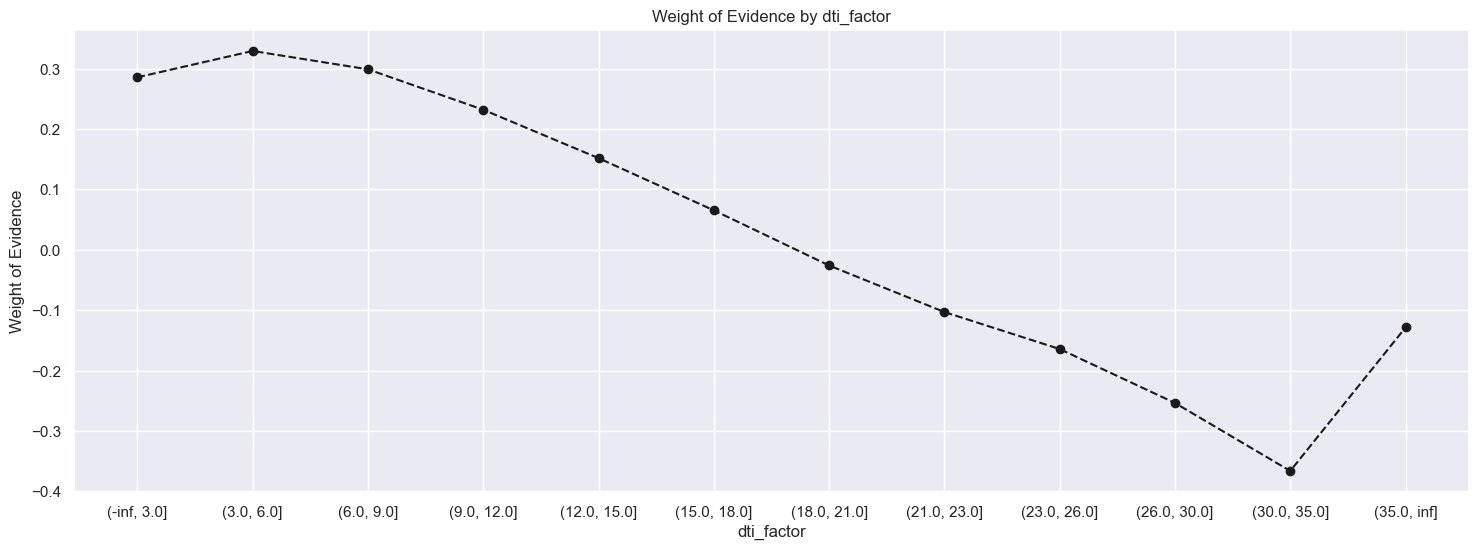

In [76]:
plot_by_woe(df_woe)

### 📊 Binning for `dti`

- The table and plot above shows the variation in woe with respect dti after final binning scheme for `dti`.
 
- We divided the groups based on **WOE patterns** while ensuring that each bin has a **decent number of observations** for statistical stability.

---
### **mths_since_last_delinq**

In [77]:
len(data_in_use['mths_since_last_delinq'].unique()), data_in_use['mths_since_last_delinq'].unique()# it contains nan values()

(172,
 array([ 13.,  nan,  31.,  34.,  51.,   8.,  40.,  62.,  32.,  23.,  79.,
         48.,   6.,  47.,  12.,  54.,  27.,  30.,  42.,  63.,  20.,  72.,
         39.,  18.,  41.,   0.,  76.,  50.,  53.,  10.,  70.,   5.,  14.,
         11.,  80.,  57.,  28.,  16.,  49.,  26.,  33.,  21.,  37.,  24.,
         36.,  60.,   4.,  71.,   3.,  69.,  29.,  45.,  35.,  17.,  66.,
         64.,  77.,  73.,  58.,  25.,  43.,  52.,   7.,  22.,  65.,  68.,
         74.,  15.,  56.,  78.,  19.,  67.,   9.,  59.,  44.,  81.,   2.,
         38.,  55.,  61.,   1.,  46., 106.,  75., 104.,  97.,  82.,  85.,
         93.,  83.,  84., 100.,  90., 138.,  92.,  88., 103.,  89., 116.,
        107., 122.,  99., 102.,  95.,  98., 121.,  94.,  96., 112., 113.,
         86., 178., 115.,  87., 108., 131.,  91., 180., 120., 128., 129.,
        105., 101., 110., 146., 161., 133., 109., 137., 142., 124., 111.,
        126., 150., 114., 123., 118., 153., 135., 132., 156., 130., 117.,
        134., 168., 160., 158., 

In [78]:
# 926173 missing values.
data_in_use['mths_since_last_delinq'].isnull().sum()

np.int64(926173)

### Note: Similar to emp_len variable, too many values are missing and we can't impute them with zero. Hence, we will create an indicator variable (new column with 1 (when `mths_since_last_delinq` is missing) and 0 (when `mths_since_last_delinq` is not missing)). Then, in the main column, we can impute zero for missing values. This way, we have created an specific indicator for our model to highlight missing values. 

In [79]:
data_in_use['mths_since_last_delinq_missing'] = data_in_use['mths_since_last_delinq'].isna().astype(int)

In [80]:
data_in_use['mths_since_last_delinq'][:5]

0    13.0
1     NaN
2    31.0
3    34.0
4     NaN
Name: mths_since_last_delinq, dtype: float64

In [81]:
data_in_use['mths_since_last_delinq_missing'][:5]

0    0
1    1
2    0
3    0
4    1
Name: mths_since_last_delinq_missing, dtype: int64

### Now, we can use our bining strategy on this variable as well. Since, it got more than 100 categories we will perform binning using pd.cut().

In [82]:
inp_data_temp = data_in_use.loc[pd.notnull(data_in_use["mths_since_last_delinq"])]
len(inp_data_temp)

882361

In [83]:
out_data_temp = output_data.loc[inp_data_temp.index]
len(out_data_temp)

882361

In [84]:
inp_data_temp['mths_since_last_delinq_factor'] = pd.cut(inp_data_temp["mths_since_last_delinq"], 50) # again starting with 50.

In [85]:
df_woe, iv_grade = calculate_IV(inp_data_temp, out_data_temp, "mths_since_last_delinq_factor", dtype = "continous")

Information Value (IV) for variable mths_since_last_delinq_factor: 0.0038


In [86]:
df_woe

,mths_since_last_delinq_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-0.226, 4.52]",38435,0.043559,32773.0,5662.0,0.042837,0.048270,0.852686,-0.119403,6.486863e-04
1,"(4.52, 9.04]",78365,0.088813,67149.0,11216.0,0.087769,0.095619,0.856875,-0.085658,6.723747e-04
2,"(9.04, 13.56]",64412,0.073000,55455.0,8957.0,0.072484,0.076360,0.860942,-0.052094,2.019215e-04
3,"(13.56, 18.08]",76539,0.086743,65947.0,10592.0,0.086198,0.090299,0.861613,-0.046478,1.906030e-04
4,"(18.08, 22.6]",59264,0.067165,51468.0,7796.0,0.067273,0.066463,0.868453,0.012119,9.820486e-06
5,"(22.6, 27.12]",71710,0.081271,62148.0,9562.0,0.081233,0.081518,0.866657,-0.003509,1.001935e-06
6,"(27.12, 31.64]",54520,0.061789,47217.0,7303.0,0.061717,0.062260,0.866049,-0.008762,4.758822e-06
7,"(31.64, 36.16]",63974,0.072503,55844.0,8130.0,0.072993,0.069310,0.872917,0.051771,1.906565e-04
8,"(36.16, 40.68]",48610,0.055091,42335.0,6275.0,0.055335,0.053496,0.870911,0.033810,6.219753e-05
9,"(40.68, 45.2]",58343,0.066121,51026.0,7317.0,0.066695,0.062379,0.874586,0.066904,2.887721e-04


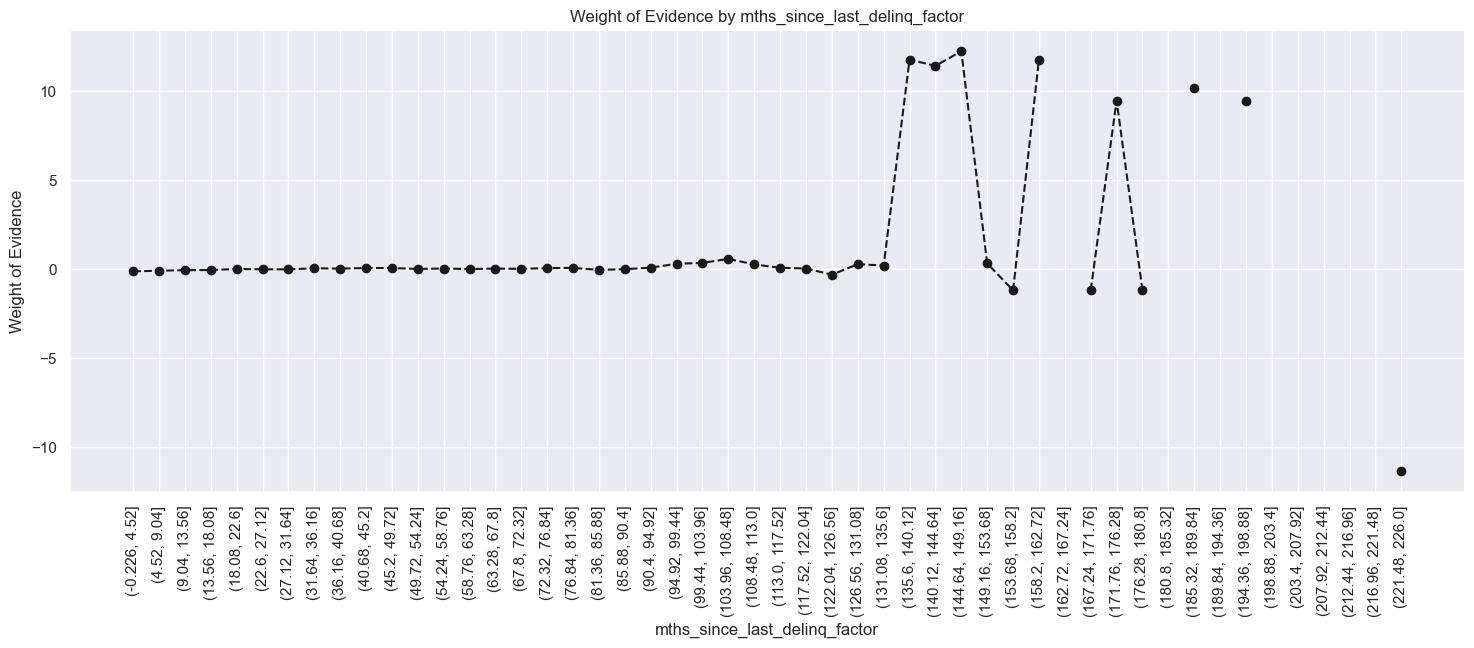

In [87]:
plot_by_woe(df_woe, rotation_of_x_axis_labels = 90)

### 📊 Observation on `mths_since_last_delinq`

From the plot above, the variable `mths_since_last_delinq` does not show significant WOE variation initially. However, on closer inspection, we observe that the number of observations beyond the 18th category **(76.84, 81.36)** is very small.

By excluding these sparse categories, the remaining data reveals a clear linear trend, the **WOE increases as `mths_since_last_delinq` increases**, suggesting that the **Probability of Default decreases the longer it's been since the last delinquency**. 

This relationship is intuitive, as borrowers who haven't had recent delinquencies are generally considered lower risk.

In [88]:
df_woe['IV'][:18].sum() # weak predictive power, so we can ignore this variable.

np.float64(0.002862569804102862)

In [89]:
df_woe[:18]

,mths_since_last_delinq_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-0.226, 4.52]",38435,0.043559,32773.0,5662.0,0.042837,0.048270,0.852686,-0.119403,0.000649
1,"(4.52, 9.04]",78365,0.088813,67149.0,11216.0,0.087769,0.095619,0.856875,-0.085658,0.000672
2,"(9.04, 13.56]",64412,0.073000,55455.0,8957.0,0.072484,0.076360,0.860942,-0.052094,0.000202
3,"(13.56, 18.08]",76539,0.086743,65947.0,10592.0,0.086198,0.090299,0.861613,-0.046478,0.000191
4,"(18.08, 22.6]",59264,0.067165,51468.0,7796.0,0.067273,0.066463,0.868453,0.012119,0.000010
5,"(22.6, 27.12]",71710,0.081271,62148.0,9562.0,0.081233,0.081518,0.866657,-0.003509,0.000001
6,"(27.12, 31.64]",54520,0.061789,47217.0,7303.0,0.061717,0.062260,0.866049,-0.008762,0.000005
7,"(31.64, 36.16]",63974,0.072503,55844.0,8130.0,0.072993,0.069310,0.872917,0.051771,0.000191
8,"(36.16, 40.68]",48610,0.055091,42335.0,6275.0,0.055335,0.053496,0.870911,0.033810,0.000062
9,"(40.68, 45.2]",58343,0.066121,51026.0,7317.0,0.066695,0.062379,0.874586,0.066904,0.000289


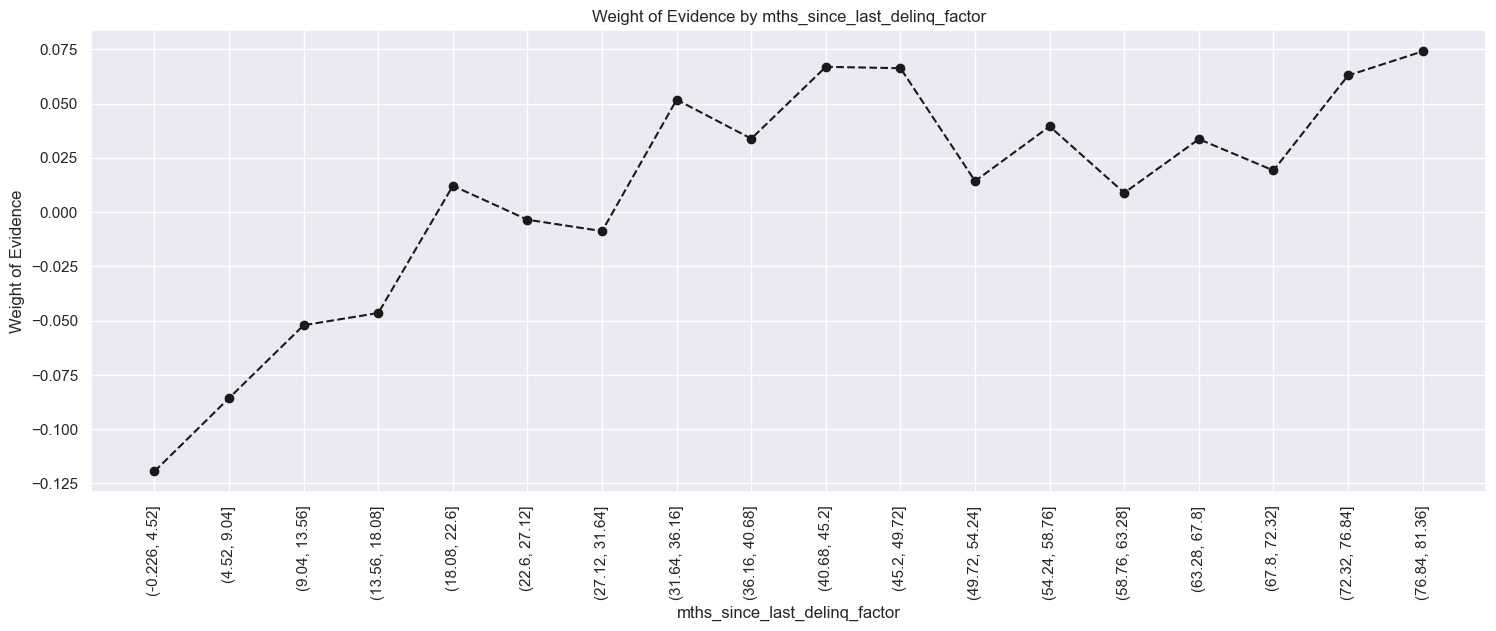

In [90]:
plot_by_woe(df_woe[:18], rotation_of_x_axis_labels = 90)

In [91]:
# Note: all nan values will be converted to zero.
data_in_use["mths_since_last_delinq:<5"] = np.where(data_in_use["mths_since_last_delinq"] <= 5.0, 1, 0)


data_in_use["mths_since_last_delinq:5-9"] = np.where((data_in_use["mths_since_last_delinq"] > 5.0) & 
                                                 (data_in_use["mths_since_last_delinq"] <= 9.0), 1, 0)

data_in_use["mths_since_last_delinq:9-18"] = np.where((data_in_use["mths_since_last_delinq"] > 9.0) & 
                                                 (data_in_use["mths_since_last_delinq"] <= 18.0), 1, 0)

data_in_use["mths_since_last_delinq:18-32"] = np.where((data_in_use["mths_since_last_delinq"] > 18.0) & 
                                                 (data_in_use["mths_since_last_delinq"] <= 32.0), 1, 0)

data_in_use["mths_since_last_delinq:32-50"] = np.where((data_in_use["mths_since_last_delinq"] > 32.0) & 
                                                 (data_in_use["mths_since_last_delinq"] <= 50.0), 1, 0)

data_in_use["mths_since_last_delinq:50-72"] = np.where((data_in_use["mths_since_last_delinq"] > 50.0) & 
                                                 (data_in_use["mths_since_last_delinq"] <= 72.0), 1, 0)

data_in_use["mths_since_last_delinq:>72"] = np.where(data_in_use["mths_since_last_delinq"] > 72.0, 1, 0)

### 🧮 Binning Strategy: `mths_since_last_delinq`

- The variable `mths_since_last_delinq` (months since last delinquency) has been binned into meaningful intervals based on the observed WOE patterns and the distribution of observations across ranges.
- **All missing (`NaN`) values are treated as zero**, based on the assumption that missing likely implies **no delinquencies recorded**.

#### 📦 Bin Definitions:

| Bin Label                              | Range (months)          | Description |
|----------------------------------------|--------------------------|-------------|
| `mths_since_last_delinq:<5`            | ≤ 5                      | Very recent delinquency |
| `mths_since_last_delinq:5-9`           | 5.01 – 9                 | Recent |
| `mths_since_last_delinq:9-18`          | 9.01 – 18                | Within past 1.5 years |
| `mths_since_last_delinq:18-32`         | 18.01 – 32               | 1.5 to ~2.5 years |
| `mths_since_last_delinq:32-50`         | 32.01 – 50               | Up to ~4 years ago |
| `mths_since_last_delinq:50-72`         | 50.01 – 72               | ~4 to 6 years |
| `mths_since_last_delinq:>72`           | > 72                     | Very old delinquencies |

- These bins aim to **capture delinquency recency**, which often has a nonlinear effect on credit risk.
- Each bin has been selected considering both the **WOE trends** and **the number of observations** in each group.
  
> **ℹ️ Note:**  
> The categories `(72.32, 76.84]` and `(76.84, 81.36]` had similar numbers of observations and nearly identical WOE values.  
> Additionally, all groups beyond `(76.84, 81.36]` had very small sample sizes.  
>  
> Therefore, these were combined into a single, broader category labeled **`>72`**, improving both model stability and interpretability.


---
### **mths_since_last_record**

In [92]:
data_in_use["mths_since_last_record"].isnull().sum() # 1521192 missing values()

np.int64(1521192)

In [93]:
# Total categories 129 (including nan).

len(data_in_use["mths_since_last_record"].unique()), data_in_use["mths_since_last_record"].unique()

(129,
 array([ nan, 117.,  81., 110.,  56.,  78.,  26.,  62.,  41.,  96.,  83.,
         89.,  75.,  28.,  95., 112.,  91.,   9.,  86.,  63., 102.,  46.,
        118., 111.,  43.,  11.,  73.,  55.,  58.,  76.,  84.,  32.,  94.,
         51.,  80.,  50.,  97.,  74.,  19.,  82.,  77., 109.,  61.,  64.,
         54.,   0.,  44.,  69.,  29., 106.,  53.,  65., 115., 104.,  87.,
        107.,  59.,  57.,  72.,  52.,  67.,  49.,  92.,  88.,  37.,  38.,
         35.,  66.,  42.,  90.,  70., 113.,  99.,  30.,  16., 105.,  79.,
        101., 103.,  60.,  48.,  24.,   7., 116.,  45.,  31., 114.,  71.,
         39.,  36.,  85., 100.,  33., 108.,  68.,  21.,   6.,  47.,  98.,
         93.,  18.,  34.,  20.,  17.,   5.,  15.,  25.,   2.,  40.,  23.,
        119.,  27.,   8.,  13.,  22.,  14.,   3.,   1.,  10.,  12.,   4.,
        121., 124., 120., 123., 122., 125., 129., 126.]))

In [94]:
# similar to "mths_since_last_delinq", creating a dummy variable to indicate missing records in "mths_since_last_record".

data_in_use['mths_since_last_record_missing'] = data_in_use['mths_since_last_record'].isna().astype(int)

In [95]:
data_in_use['mths_since_last_record'][:5]

0      NaN
1      NaN
2    117.0
3      NaN
4     81.0
Name: mths_since_last_record, dtype: float64

In [96]:
data_in_use['mths_since_last_record_missing'][:5]

0    1
1    1
2    0
3    1
4    0
Name: mths_since_last_record_missing, dtype: int64

In [97]:
inp_data_temp = data_in_use.loc[pd.notnull(data_in_use["mths_since_last_record"])]
out_data_temp = output_data.loc[inp_data_temp.index]
len(inp_data_temp), len(out_data_temp)

(287342, 287342)

In [98]:
inp_data_temp['mths_since_last_record_factor'] = pd.cut(inp_data_temp["mths_since_last_record"], 50) # again starting with 50.

In [99]:
df_woe, iv_grade = calculate_IV(inp_data_temp, out_data_temp, "mths_since_last_record_factor", dtype = "continous")

Information Value (IV) for variable mths_since_last_record_factor: 0.0080


In [100]:
df_woe

,mths_since_last_record_factor,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,"(-0.129, 2.58]",1284,0.004469,981.0,303.0,0.004032,0.006876,0.764019,-0.533615,1.517199e-03
1,"(2.58, 5.16]",917,0.003191,747.0,170.0,0.003071,0.003858,0.814613,-0.228188,1.795981e-04
2,"(5.16, 7.74]",865,0.003010,714.0,151.0,0.002935,0.003427,0.825434,-0.154851,7.611880e-05
3,"(7.74, 10.32]",1585,0.005516,1314.0,271.0,0.005401,0.006150,0.829022,-0.129742,9.708212e-05
4,"(10.32, 12.9]",1195,0.004159,974.0,221.0,0.004004,0.005015,0.815063,-0.225206,2.277419e-04
5,"(12.9, 15.48]",1864,0.006487,1579.0,285.0,0.006491,0.006467,0.847103,0.003603,8.412342e-08
6,"(15.48, 18.06]",2015,0.007013,1690.0,325.0,0.006947,0.007375,0.838710,-0.059796,2.559661e-05
7,"(18.06, 20.64]",1542,0.005366,1300.0,242.0,0.005344,0.005492,0.843061,-0.027273,4.029383e-06
8,"(20.64, 23.22]",2387,0.008307,1999.0,388.0,0.008217,0.008805,0.837453,-0.069057,4.057146e-05
9,"(23.22, 25.8]",1890,0.006578,1569.0,321.0,0.006450,0.007284,0.830159,-0.121702,1.015820e-04


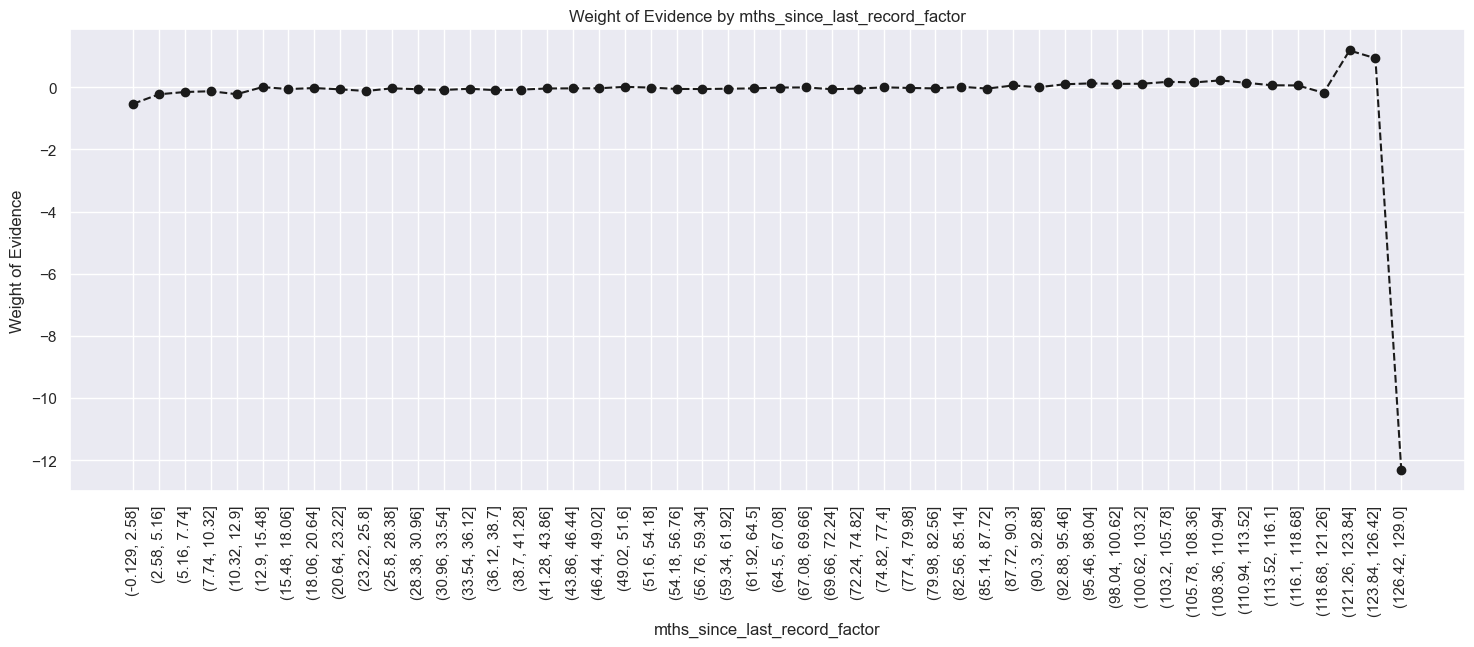

In [101]:
plot_by_woe(df_woe, rotation_of_x_axis_labels = 90)

### ℹ️ Information Value (IV) Analysis for `mths_since_last_record_factor`

- The Information Value (IV) for `mths_since_last_record_factor` is **0.0080**, which falls into the **"not predictive"** range.
- Upon examining the distribution of observations across its categories, we observed that — with the exception of a few — the number of records in each bin was relatively uniform.
- However, the **WOE plot shows minimal variation** across bins, essentially forming a horizontal line. This indicates that the variable does not meaningfully distinguish between good and bad outcomes.
  
📌 **Conclusion**: Given the low IV and flat WOE trend, we consider this variable to have **negligible predictive power** and will exclude it from the model.

#

In [102]:
len(data_in_use.keys())

397

In [103]:
len(data_in_use)

1808534

In [104]:
data_in_use.to_csv('dataset/train_input2.csv', index=False) # 397 columns, 1808534 rows.

In [105]:
### Change the cell above to markdown before running this cell.

#data_in_use.to_csv('dataset/test_input2.csv', index=False) # 397 columns, 452134 rows.

### In order to test our model on the test data, we need to have the same dummy variables in our test_input dataset. To do that, we can just change the name of the datasets that we initialised earlier.

---

> **Training data**
>>data_in_use = pd.read_csv('dataset/train_input1.csv') # Loading updated data.
>>
>>output_data = pd.read_csv('dataset/train_output.csv') # Loading updated data.

> **Testing data**

>>data_in_use = pd.read_csv('dataset/test_input1.csv') # Loading updated data.
>>
>>output_data = pd.read_csv('dataset/test_output.csv') # Loading updated data.
>>
> **Saving data**
>> data_in_use.to_csv('dataset/train_input2.csv', index=False)
>>
>> data_in_use.to_csv('dataset/test_input2.csv', index=False)